In [1]:
from cProfile import label
import os
from pyclbr import Function
from turtle import color
from xml.etree.ElementTree import PI
import math 
from sympy import apart
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from dolfin import *
from matplotlib import pyplot
from ufl import nabla_div, nabla_grad, elem_op
import numpy as np
from ufl.tensors import as_matrix
import  sys
import mshr

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  1 14:26:23 2021
@author: SebastianG
"""



parameters['allow_extrapolation'] = True

def create_mesh(mesh, cell_type, prune_z=False):
        cells = mesh.get_cells_type(cell_type)
        cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
        out_mesh = meshio.Mesh(points=mesh.points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
        if prune_z:
            out_mesh.prune_z_0()
        return out_mesh
print('creando malla..')

nombre = 'radial_compresion'


   


#%%

mesh=RectangleMesh(Point(0.0, 0.0), Point(1,-0.5), 30, 15,"crossed")
# cell_markers =  MeshFunction("bool", mesh,mesh.topology().dim())
# cell_markers.set_all(False)
# class fine0(SubDomain):
#         def inside(self, x, on_boundary):
#             return  (x[1]>-13) and (x[0]<=3)
# fine0().mark(cell_markers, True)
# mesh = refine(mesh, cell_markers)

# cell_markers =  MeshFunction("bool", mesh,mesh.topology().dim())
# cell_markers.set_all(False)
# class fine1(SubDomain):
#         def inside(self, x, on_boundary):
#             return  (x[0]<=2 and x[1]>=-12) 
# fine1().mark(cell_markers, True)
# mesh = refine(mesh, cell_markers)
# cell_markers2 =  MeshFunction("bool", mesh,mesh.topology().dim())
# cell_markers2.set_all(False)

# class fine2(SubDomain):
#         def inside(self, x, on_boundary):
#             return  (x[0]<=1 and x[1]>=-11) 
# fine2().mark(cell_markers2, True)
# mesh = refine(mesh, cell_markers2)
# cell_markers3 =  MeshFunction("bool", mesh,mesh.topology().dim())
# cell_markers3.set_all(False)
# class fine3(SubDomain):
#         def inside(self, x, on_boundary):
#             return (x[0]<=0.5 and x[1]>=-10) 
# fine3().mark(cell_markers3, True)
# mesh = refine(mesh, cell_markers3)

# cell_markers4 =  MeshFunction("bool", mesh,mesh.topology().dim())
# cell_markers4.set_all(False)
# class fine4(SubDomain):
#         def inside(self, x, on_boundary):
#             return (x[0]<=0.2 and x[1]>=-9) 
# fine4().mark(cell_markers4, True)
# mesh = refine(mesh, cell_markers4)

contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
tol=1E-6
class L(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (abs(x[0])< tol )#and (x[1]>-I)
class R(SubDomain):
        def inside(self,x,on_boundary):
             return on_boundary and  abs(x[0]-1)< tol        

class walls(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary

walls().mark(contorno, 3)
L().mark(contorno, 1)
R().mark(contorno, 2)

# simetry().mark(contorno,6)

# subdominio = MeshFunction("size_t", mesh, mesh.topology().dim())
# tol=1E-2
# class S1(SubDomain):
#         def inside(self, x, on_boundary):
#             return  (x[1])>= -3
# class S2(SubDomain):
#         def inside(self, x, on_boundary):
#             return  ((x[1])<=-3) and ((x[1])>=(-8)) 
# class S3(SubDomain):
#         def inside(self, x, on_boundary):
#             return (x[1])<=(-8)
# S2().mark(subdominio, 2)
# S1().mark(subdominio, 1)
# S3().mark(subdominio, 3)
vtkfile_u = XDMFFile("%s.results/displacement.xdmf" % (nombre))
vtkfile_fs = XDMFFile("%s.results/Mohr-Coulomb_Fs.xdmf" % (nombre))
vtkfile_p = XDMFFile("%s.results/Pressure.xdmf" % (nombre))
vtkfile_flow = XDMFFile("%s.results/flow.xdmf" % (nombre))
vtkfile_bounds = XDMFFile("%s.results/bounds.xdmf" % (nombre))
#material 

vtkfile_u.parameters["flush_output"] = True
vtkfile_fs.parameters["flush_output"] = True
vtkfile_p.parameters["flush_output"] = True
vtkfile_flow.parameters["flush_output"] = True
vtkfile_bounds.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False
vtkfile_fs.parameters["rewrite_function_mesh"] = False
vtkfile_p.parameters["rewrite_function_mesh"] = False
vtkfile_flow.parameters["rewrite_function_mesh"] = False
vtkfile_bounds.parameters["rewrite_function_mesh"] = False
    
class K(UserExpression):
    def __init__(self, subdominio, k_0, k_1,k_2, **kwargs):
        super().__init__(**kwargs)
        self.subdominio = subdominio
        self.k_0 = k_0
        self.k_1 = k_1
        self.k_2 = k_2

    def eval_cell(self, values, x, cell):
        if self.subdominio[cell.index] == 1:
            values[0] = self.k_0
        elif self.subdominio[cell.index] == 2:
            values[0] = self.k_1
        else:
            values[0]=self.k_2

class KM(UserExpression):
    def __init__(self, subdominio, k_0, k_1,k_2, **kwargs):
        super().__init__(**kwargs)
        self.subdominio = subdominio
        self.k_0 = k_0
        self.k_1 = k_1
        self.k_2 = k_2

    def value_shape(self):
        return (2,2)

    def eval_cell(self, values, x, cell):
        if self.subdominio[cell.index] == 1:
            values = self.k_0
        elif self.subdominio[cell.index] == 2:
            values = self.k_1
        else:
            values=self.k_2

creando malla..


In [3]:
def cildiv(v):
    return Dx(v[0],0)+v[0]/x[0]+Dx(v[1],1)
#deformacion
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    
#esfuerzo 
def sigma(u):
    return lmbda*tr(epsilon(u))*Identity(d) + 2*mu*epsilon(u)
ele_p  = FiniteElement("P",mesh.ufl_cell(), 1) # pressure
ele_u  = VectorElement("P",mesh.ufl_cell(), 1) # solid displacement
W = MixedElement([ele_p, ele_u])
W = FunctionSpace(mesh, W)
U = TrialFunction(W)
V = TestFunction(W)
Z= FunctionSpace(mesh, 'P', 1)
Z_v = VectorFunctionSpace(mesh, 'P', 1)
TS = TensorFunctionSpace(mesh, "DG", 0)

p, u = split(U)
q, v = split(V)
steps =18000
n=FacetNormal(mesh)#vector normal 
x = SpatialCoordinate(mesh)

Ti=900#tiempo total
delta= Ti/steps
dt=Constant((delta))
t=0 # tiempo inicial
# B_s=1E-11
# B_m=1E-10
B_f=4.4E-10
Poro=0.3
r=0.4
nu=0.3#coeficiente de poisson  
flo=Constant((0,0))
E=20700E3#K(subdominio,20700E3,1E6,20720E3)# #modulo elasticidad
mu = E/(2*(1+nu))#coeficientes de Lame
lmbda = E*nu/((1+nu)*(1-2*nu))#coeficientes de Lame
B_m=(E/(3*(1-2*nu)))**(-1)
B_s=0
alpha=(1-B_s/B_m) #biotcoef
s_coef=(alpha-Poro)*B_s +Poro*B_f
theta =18.94#K(subdominio,18.94,20.61,23.27) #angulos friccion interna
C=15530#K(subdominio,15530,10350,18650) #cohesion
k=1E-8#K(subdominio,1E-8,1E-1,1E-8)

# E=B_m**(-1)*3*(1-2*nu)#modulo elasticidad 
mu = E/(2*(1+nu))#coeficientes de Lame
lmbda = E*nu/((1+nu)*(1-2*nu))#coeficientes de Lame




d = u.geometric_dimension()
f = Constant((0, 0))
lam=Constant((0))
ds = Measure('ds', domain=mesh, subdomain_data=contorno)


#theta=s/(1-s)
gam =Constant((9806.65))


def envFalla(O1,O3,Theta,c):#envolvente de falla experimental
    ang=Theta#angulo de friccion interno 
    c=c#cohesión
    return abs((O1-O3)/2 *sin(ang)+c*cos(ang))

def sigma_1 (T):
    c=det(T)
    b =-tr(T)
    return -b/2 + sqrt(b**2-4*c)/2
def sigma_3(T):
    c=det(T)
    b =-tr(T)
    return -b/2 - sqrt(b**2-4*c)/2

bp1=DirichletBC(W.sub(0),Constant((0)),contorno,2)
bc1 = DirichletBC(W.sub(1), Constant((0.0,0.0)),contorno,2)
bc2 = DirichletBC(W.sub(1).sub(1), Constant((0.0)),contorno,3)


x_n=Expression(('0','0','0'), gam=gam,degree=5)
X_n = Function(W)
X_n=interpolate(x_n, W)
p_n, u_n = split(X_n)

X_nn=Function(W)
X_nn=interpolate(x_n, W)
p_nn, u_nn = split(X_nn)
X_nnn=Function(W)
X_nnn=interpolate(x_n, W)
p_nnn, u_nnn = split(X_nnn)
#
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
#pconst= [11/6,-3,3/2,-1/3] #bdf 3
pconst=[1,-1,0,0] #bdf1
du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn

divu=    pconst[0]*(nabla_div(u)*x[0]    + u[0])
divu_n=  pconst[1]*(nabla_div(u_n)*x[0]  + u_n[0])
divu_nn= pconst[2]*(nabla_div(u_nn)*x[0] + u_nn[0])
divu_nnn=pconst[3]*(nabla_div(u_nnn)*x[0]+ u_nnn[0])
divu_t= divu+divu_n +divu_nn+divu_nnn

dp=pconst[0]*p
dp_n=pconst[1]*p_n
dp_nn=pconst[2]*p_nn
dp_nnn=pconst[3]*p_nnn
dp_t=dp+dp_n+dp_nn+dp_nnn

ds = Measure('ds', domain=mesh, subdomain_data=contorno)

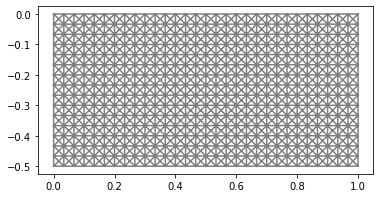

In [4]:
plot(mesh)

In [5]:


T=Constant((0,0))
F1 =  inner(sigma(u), epsilon(v))*x[0]*dx +v[0]*lmbda*nabla_div(u)*dx + (lmbda+2*mu)*v[0]*u[0]/x[0]*dx  -alpha*p*nabla_div(v)*x[0]*dx-alpha*p*v[0]*dx\
    -inner(T, v)*ds(subdomain_id=1, domain=mesh, subdomain_data=contorno)



F2 = dt*k*inner(nabla_grad(q),nabla_grad(p))*x[0]*dx\
+ alpha*divu_t*q*dx +Constant((s_coef))*(dp_t)*q*x[0]*dx\
-dt*(inner(Constant((0,0)),n))*q*ds(subdomain_id=(3,1),domain=mesh, subdomain_data=contorno)


In [6]:


outfile = File("%s.results/mesh.pvd" % (nombre))
outfile << mesh

X = Function(W)
L_momentum =lhs(F1)
R_momentum =rhs(F1)
L_mass=lhs(F2)
R_mass=rhs(F2)
L=L_momentum+L_mass
R=R_momentum+R_mass
for pot in range(steps):
    
    disp = Expression(('t/10000'),t=t,degree=1)
    bc3 = DirichletBC(W.sub(1).sub(0), disp,contorno,1)
    bcs=[bc1,bc2,bc3,bp1]
    A=assemble(L)
    b=assemble(R)
    [bc.apply(A) for bc in bcs]
    [bc.apply(b) for bc in bcs]
    print('solver')
    solve(A, X.vector(), b)
    print('solver end')
    X_nnn.assign(X_nn)
    p_nnn, u_nnn = split(X_nnn)
    X_nn.assign(X_n)
    p_nn, u_nn = split(X_nn)
    disp_r=X-X_n
    disp_r_real = Function(W)
    disp_r=project(disp_r, W)
    ALE.move(mesh,disp_r.sub(1))
    X_n.assign(X)
    p_n, u_n = split(X_n)
    
    u_=project(u_n,Z_v)
    p_=project(p_n,Z)
    for i in range(100):
        mesh.smooth()
    if pot % 100== 0:
        print('postproces')
        s = sigma(u_)
        
        cauchy=project(s,TS)

        o1 = sigma_1(cauchy)
        
        o2 = sigma_3(cauchy)
        
        tm=(o1-o2)/2
        fail = envFalla(o1, o2,theta,C)
        fs = tm
        fs=project(fs,Z)
        flow=-k*grad(p_)
        flow=project(flow,Z_v)
        fs.rename(" mean stress", "mean stress") ;vtkfile_fs.write(fs,t)
        u_.rename("displacement", "displacement") ;vtkfile_u.write(u_,t)
        flow.rename("flow", "flow") ;vtkfile_flow.write(flow)
        p_.rename("pressure", "pressure"); vtkfile_p.write(p_)
    
        outfile << mesh  
    print('u max:',u_.vector().get_local().max(),'step', pot, 'of', steps,'time:',t)
    print('p max:', p_.vector().get_local().max())
    print('p min:', p_.vector().get_local().min())
    
    t=t+delta

solver
solver end
postproces
u max: 0.0 step 0 of 18000 time: 0
p max: 0.0
p min: 0.0
solver
solver end
u max: 5e-06 step 1 of 18000 time: 0.05
p max: 0.00515570093776
p min: -119.371101604
solver
solver end
u max: 1e-05 step 2 of 18000 time: 0.1
p max: 0.00429910525649
p min: -136.184097905
solver
solver end
u max: 1.5e-05 step 3 of 18000 time: 0.15000000000000002
p max: 0.00327709612586
p min: -145.25830971
solver
solver end
u max: 2e-05 step 4 of 18000 time: 0.2
p max: 0.00195466315295
p min: -151.635715299
solver
solver end
u max: 2.5e-05 step 5 of 18000 time: 0.25
p max: 0.00119365498644
p min: -156.574416268
solver
solver end
u max: 3e-05 step 6 of 18000 time: 0.3
p max: 0.000274557822485
p min: -160.586711086
solver
solver end
u max: 3.5e-05 step 7 of 18000 time: 0.35
p max: 2.21552077989e-18
p min: -163.938410445
solver
solver end
u max: 4e-05 step 8 of 18000 time: 0.39999999999999997
p max: 2.36621547482e-18
p min: -166.790501756
solver
solver end
u max: 4.5e-05 step 9 of 1800

u max: 0.00035 step 70 of 18000 time: 3.4999999999999956
p max: 0.0405936154146
p min: -216.680562299
solver
solver end
u max: 0.000355 step 71 of 18000 time: 3.5499999999999954
p max: 0.0419162039663
p min: -217.247434793
solver
solver end
u max: 0.00036 step 72 of 18000 time: 3.599999999999995
p max: 0.04323968791
p min: -217.812232836
solver
solver end
u max: 0.000365 step 73 of 18000 time: 3.649999999999995
p max: 0.04456405886
p min: -218.374972951
solver
solver end
u max: 0.00037 step 74 of 18000 time: 3.699999999999995
p max: 0.0458893087355
p min: -218.935671418
solver
solver end
u max: 0.000375 step 75 of 18000 time: 3.7499999999999947
p max: 0.0472154297197
p min: -219.494344287
solver
solver end
u max: 0.00038 step 76 of 18000 time: 3.7999999999999945
p max: 0.048542414227
p min: -220.051007392
solver
solver end
u max: 0.000385 step 77 of 18000 time: 3.8499999999999943
p max: 0.0498702548744
p min: -220.605676364
solver
solver end
u max: 0.00039 step 78 of 18000 time: 3.8999

u max: 0.0007 step 140 of 18000 time: 6.999999999999983
p max: 0.134994391347
p min: -252.105228778
solver
solver end
u max: 0.000705 step 141 of 18000 time: 7.049999999999983
p max: 0.136365513273
p min: -252.558310334
solver
solver end
u max: 0.00071 step 142 of 18000 time: 7.099999999999983
p max: 0.137737168718
p min: -253.010132615
solver
solver end
u max: 0.000715 step 143 of 18000 time: 7.149999999999983
p max: 0.139109354158
p min: -253.460703754
solver
solver end
u max: 0.00072 step 144 of 18000 time: 7.199999999999982
p max: 0.140482066105
p min: -253.910031811
solver
solver end
u max: 0.000725 step 145 of 18000 time: 7.249999999999982
p max: 0.1418553011
p min: -254.358124775
solver
solver end
u max: 0.00073 step 146 of 18000 time: 7.299999999999982
p max: 0.143229055718
p min: -254.804990565
solver
solver end
u max: 0.000735 step 147 of 18000 time: 7.349999999999982
p max: 0.144603326561
p min: -255.250637029
solver
solver end
u max: 0.00074 step 148 of 18000 time: 7.399999

u max: 0.001045 step 209 of 18000 time: 10.450000000000014
p max: 0.248107135984
p min: -280.78499275
solver
solver end
u max: 0.00105 step 210 of 18000 time: 10.500000000000014
p max: 0.249985330028
p min: -281.167060611
solver
solver end
u max: 0.001055 step 211 of 18000 time: 10.550000000000015
p max: 0.251864343406
p min: -281.548294889
solver
solver end
u max: 0.00106 step 212 of 18000 time: 10.600000000000016
p max: 0.253744171522
p min: -281.928700163
solver
solver end
u max: 0.001065 step 213 of 18000 time: 10.650000000000016
p max: 0.255624809818
p min: -282.308280976
solver
solver end
u max: 0.00107 step 214 of 18000 time: 10.700000000000017
p max: 0.257506253765
p min: -282.687041838
solver
solver end
u max: 0.001075 step 215 of 18000 time: 10.750000000000018
p max: 0.259388498874
p min: -283.064987221
solver
solver end
u max: 0.00108 step 216 of 18000 time: 10.800000000000018
p max: 0.261271540691
p min: -283.442121567
solver
solver end
u max: 0.001085 step 217 of 18000 tim

u max: 0.001395 step 279 of 18000 time: 13.950000000000063
p max: 0.387496213721
p min: -305.738611048
solver
solver end
u max: 0.0014 step 280 of 18000 time: 14.000000000000064
p max: 0.389843719077
p min: -306.071726252
solver
solver end
u max: 0.001405 step 281 of 18000 time: 14.050000000000065
p max: 0.392192201086
p min: -306.404258815
solver
solver end
u max: 0.00141 step 282 of 18000 time: 14.100000000000065
p max: 0.394541655025
p min: -306.736211494
solver
solver end
u max: 0.001415 step 283 of 18000 time: 14.150000000000066
p max: 0.396892076198
p min: -307.067587029
solver
solver end
u max: 0.00142 step 284 of 18000 time: 14.200000000000067
p max: 0.399243459943
p min: -307.398388142
solver
solver end
u max: 0.001425 step 285 of 18000 time: 14.250000000000068
p max: 0.40159580163
p min: -307.728617534
solver
solver end
u max: 0.00143 step 286 of 18000 time: 14.300000000000068
p max: 0.403949096662
p min: -308.058277891
solver
solver end
u max: 0.001435 step 287 of 18000 time

u max: 0.00174 step 348 of 18000 time: 17.400000000000112
p max: 0.55154277264
p min: -327.486699502
solver
solver end
u max: 0.001745 step 349 of 18000 time: 17.450000000000113
p max: 0.553948058411
p min: -327.785228244
solver
solver end
u max: 0.00175 step 350 of 18000 time: 17.500000000000114
p max: 0.556354058008
p min: -328.083328065
solver
solver end
u max: 0.001755 step 351 of 18000 time: 17.550000000000114
p max: 0.558760768404
p min: -328.38100074
solver
solver end
u max: 0.00176 step 352 of 18000 time: 17.600000000000115
p max: 0.561168186593
p min: -328.678248033
solver
solver end
u max: 0.001765 step 353 of 18000 time: 17.650000000000116
p max: 0.56357630958
p min: -328.975071698
solver
solver end
u max: 0.00177 step 354 of 18000 time: 17.700000000000117
p max: 0.565985134398
p min: -329.271473477
solver
solver end
u max: 0.001775 step 355 of 18000 time: 17.750000000000117
p max: 0.56839465809
p min: -329.567455103
solver
solver end
u max: 0.00178 step 356 of 18000 time: 1

u max: 0.002085 step 417 of 18000 time: 20.85000000000016
p max: 0.719037972242
p min: -347.16352642
solver
solver end
u max: 0.00209 step 418 of 18000 time: 20.900000000000162
p max: 0.721486264355
p min: -347.436126877
solver
solver end
u max: 0.002095 step 419 of 18000 time: 20.950000000000163
p max: 0.723935098112
p min: -347.708399535
solver
solver end
u max: 0.0021 step 420 of 18000 time: 21.000000000000163
p max: 0.726384471486
p min: -347.980345592
solver
solver end
u max: 0.002105 step 421 of 18000 time: 21.050000000000164
p max: 0.728834382448
p min: -348.251966236
solver
solver end
u max: 0.00211 step 422 of 18000 time: 21.100000000000165
p max: 0.731284828997
p min: -348.523262652
solver
solver end
u max: 0.002115 step 423 of 18000 time: 21.150000000000166
p max: 0.733735809123
p min: -348.794236015
solver
solver end
u max: 0.00212 step 424 of 18000 time: 21.200000000000166
p max: 0.736187320841
p min: -349.064887498
solver
solver end
u max: 0.002125 step 425 of 18000 time:

u max: 0.002435 step 487 of 18000 time: 24.35000000000021
p max: 0.891624516722
p min: -365.513974612
solver
solver end
u max: 0.00244 step 488 of 18000 time: 24.40000000000021
p max: 0.894106357513
p min: -365.76620096
solver
solver end
u max: 0.002445 step 489 of 18000 time: 24.450000000000212
p max: 0.896588620717
p min: -366.018169766
solver
solver end
u max: 0.00245 step 490 of 18000 time: 24.500000000000213
p max: 0.89907130492
p min: -366.269881863
solver
solver end
u max: 0.002455 step 491 of 18000 time: 24.550000000000214
p max: 0.90155440872
p min: -366.521338083
solver
solver end
u max: 0.00246 step 492 of 18000 time: 24.600000000000215
p max: 0.904037930717
p min: -366.772539249
solver
solver end
u max: 0.002465 step 493 of 18000 time: 24.650000000000215
p max: 0.906521869515
p min: -367.023486183
solver
solver end
u max: 0.00247 step 494 of 18000 time: 24.700000000000216
p max: 0.909006223737
p min: -367.274179704
solver
solver end
u max: 0.002475 step 495 of 18000 time: 2

u max: 0.00278 step 556 of 18000 time: 27.80000000000026
p max: 1.06379407609
p min: -382.353809262
solver
solver end
u max: 0.002785 step 557 of 18000 time: 27.85000000000026
p max: 1.06630208046
p min: -382.590026896
solver
solver end
u max: 0.00279 step 558 of 18000 time: 27.90000000000026
p max: 1.0690540833
p min: -382.826036109
solver
solver end
u max: 0.002795 step 559 of 18000 time: 27.950000000000262
p max: 1.07191141212
p min: -383.061837504
solver
solver end
u max: 0.0028 step 560 of 18000 time: 28.000000000000263
p max: 1.07476927744
p min: -383.297431682
solver
solver end
u max: 0.002805 step 561 of 18000 time: 28.050000000000264
p max: 1.07762767764
p min: -383.532819239
solver
solver end
u max: 0.00281 step 562 of 18000 time: 28.100000000000264
p max: 1.08048661114
p min: -383.768000771
solver
solver end
u max: 0.002815 step 563 of 18000 time: 28.150000000000265
p max: 1.08334607634
p min: -384.002976869
solver
solver end
u max: 0.00282 step 564 of 18000 time: 28.2000000

u max: 0.00313 step 626 of 18000 time: 31.30000000000031
p max: 1.26449966779
p min: -398.416396988
solver
solver end
u max: 0.003135 step 627 of 18000 time: 31.35000000000031
p max: 1.26739015532
p min: -398.639345784
solver
solver end
u max: 0.00314 step 628 of 18000 time: 31.40000000000031
p max: 1.27028108486
p min: -398.86212258
solver
solver end
u max: 0.003145 step 629 of 18000 time: 31.450000000000312
p max: 1.27317245522
p min: -399.08472782
solver
solver end
u max: 0.00315 step 630 of 18000 time: 31.500000000000313
p max: 1.27606426523
p min: -399.30716195
solver
solver end
u max: 0.003155 step 631 of 18000 time: 31.550000000000313
p max: 1.27895651368
p min: -399.529425411
solver
solver end
u max: 0.00316 step 632 of 18000 time: 31.600000000000314
p max: 1.2818491994
p min: -399.751518644
solver
solver end
u max: 0.003165 step 633 of 18000 time: 31.650000000000315
p max: 1.28474232122
p min: -399.973442086
solver
solver end
u max: 0.00317 step 634 of 18000 time: 31.700000000

u max: 0.00348 step 696 of 18000 time: 34.80000000000016
p max: 1.46784016078
p min: -413.630250588
solver
solver end
u max: 0.003485 step 697 of 18000 time: 34.85000000000016
p max: 1.47075895553
p min: -413.842143141
solver
solver end
u max: 0.00349 step 698 of 18000 time: 34.900000000000155
p max: 1.47367811941
p min: -414.053890926
solver
solver end
u max: 0.003495 step 699 of 18000 time: 34.95000000000015
p max: 1.47659765153
p min: -414.265494282
solver
solver end
postproces
u max: 0.0035 step 700 of 18000 time: 35.00000000000015
p max: 1.47951755096
p min: -414.476953543
solver
solver end
u max: 0.003505 step 701 of 18000 time: 35.050000000000146
p max: 1.48243781684
p min: -414.688269046
solver
solver end
u max: 0.00351 step 702 of 18000 time: 35.10000000000014
p max: 1.48535844826
p min: -414.899441123
solver
solver end
u max: 0.003515 step 703 of 18000 time: 35.15000000000014
p max: 1.48827944434
p min: -415.110470106
solver
solver end
u max: 0.00352 step 704 of 18000 time: 3

u max: 0.003835 step 767 of 18000 time: 38.34999999999996
p max: 1.67594351116
p min: -428.332978494
solver
solver end
u max: 0.00384 step 768 of 18000 time: 38.399999999999956
p max: 1.67888645687
p min: -428.535362776
solver
solver end
u max: 0.003845 step 769 of 18000 time: 38.44999999999995
p max: 1.68182971545
p min: -428.737623364
solver
solver end
u max: 0.00385 step 770 of 18000 time: 38.49999999999995
p max: 1.6847732862
p min: -428.939760516
solver
solver end
u max: 0.003855 step 771 of 18000 time: 38.54999999999995
p max: 1.68771716844
p min: -429.141774491
solver
solver end
u max: 0.00386 step 772 of 18000 time: 38.599999999999945
p max: 1.69066136149
p min: -429.343665548
solver
solver end
u max: 0.003865 step 773 of 18000 time: 38.64999999999994
p max: 1.69360586464
p min: -429.545433943
solver
solver end
u max: 0.00387 step 774 of 18000 time: 38.69999999999994
p max: 1.69655067722
p min: -429.747079932
solver
solver end
u max: 0.003875 step 775 of 18000 time: 38.74999999

solver end
u max: 0.004185 step 837 of 18000 time: 41.84999999999976
p max: 1.89961005449
p min: -442.214566192
solver
solver end
u max: 0.00419 step 838 of 18000 time: 41.89999999999976
p max: 1.90289665927
p min: -442.408871794
solver
solver end
u max: 0.004195 step 839 of 18000 time: 41.949999999999754
p max: 1.9061836494
p min: -442.603069855
solver
solver end
u max: 0.0042 step 840 of 18000 time: 41.99999999999975
p max: 1.90947102412
p min: -442.797160577
solver
solver end
u max: 0.004205 step 841 of 18000 time: 42.04999999999975
p max: 1.91275878265
p min: -442.991144166
solver
solver end
u max: 0.00421 step 842 of 18000 time: 42.099999999999746
p max: 1.91604692423
p min: -443.185020823
solver
solver end
u max: 0.004215 step 843 of 18000 time: 42.14999999999974
p max: 1.91933544809
p min: -443.37879075
solver
solver end
u max: 0.00422 step 844 of 18000 time: 42.19999999999974
p max: 1.92262435348
p min: -443.572454148
solver
solver end
u max: 0.004225 step 845 of 18000 time: 42

u max: 0.004535 step 907 of 18000 time: 45.34999999999956
p max: 2.13056298916
p min: -455.566826567
solver
solver end
u max: 0.00454 step 908 of 18000 time: 45.39999999999956
p max: 2.13387483572
p min: -455.75406243
solver
solver end
u max: 0.004545 step 909 of 18000 time: 45.449999999999555
p max: 2.13718701928
p min: -455.941203546
solver
solver end
u max: 0.00455 step 910 of 18000 time: 45.49999999999955
p max: 2.14049953921
p min: -456.128250076
solver
solver end
u max: 0.004555 step 911 of 18000 time: 45.54999999999955
p max: 2.1438123949
p min: -456.315202183
solver
solver end
u max: 0.00456 step 912 of 18000 time: 45.59999999999955
p max: 2.14712558572
p min: -456.50206003
solver
solver end
u max: 0.004565 step 913 of 18000 time: 45.649999999999544
p max: 2.15043911109
p min: -456.688823778
solver
solver end
u max: 0.00457 step 914 of 18000 time: 45.69999999999954
p max: 2.15375297041
p min: -456.875493587
solver
solver end
u max: 0.004575 step 915 of 18000 time: 45.7499999999

u max: 0.004885 step 977 of 18000 time: 48.84999999999936
p max: 2.3631741071
p min: -468.452997498
solver
solver end
u max: 0.00489 step 978 of 18000 time: 48.89999999999936
p max: 2.36650815754
p min: -468.633968469
solver
solver end
u max: 0.004895 step 979 of 18000 time: 48.949999999999356
p max: 2.36984250623
p min: -468.814854976
solver
solver end
u max: 0.0049 step 980 of 18000 time: 48.99999999999935
p max: 2.37317715266
p min: -468.995657151
solver
solver end
u max: 0.004905 step 981 of 18000 time: 49.04999999999935
p max: 2.37651209634
p min: -469.176375125
solver
solver end
u max: 0.00491 step 982 of 18000 time: 49.09999999999935
p max: 2.37984733679
p min: -469.357009029
solver
solver end
u max: 0.004915 step 983 of 18000 time: 49.149999999999345
p max: 2.38318287352
p min: -469.537558995
solver
solver end
u max: 0.00492 step 984 of 18000 time: 49.19999999999934
p max: 2.38651870601
p min: -469.718025153
solver
solver end
u max: 0.004925 step 985 of 18000 time: 49.249999999

u max: 0.00523 step 1046 of 18000 time: 52.299999999999166
p max: 2.59389851131
p min: -480.748435055
solver
solver end
u max: 0.005235 step 1047 of 18000 time: 52.34999999999916
p max: 2.59725205036
p min: -480.923868446
solver
solver end
u max: 0.00524 step 1048 of 18000 time: 52.39999999999916
p max: 2.60060585665
p min: -481.099225642
solver
solver end
u max: 0.005245 step 1049 of 18000 time: 52.44999999999916
p max: 2.60395992976
p min: -481.27450675
solver
solver end
u max: 0.00525 step 1050 of 18000 time: 52.499999999999154
p max: 2.60731426929
p min: -481.449711879
solver
solver end
u max: 0.005255 step 1051 of 18000 time: 52.54999999999915
p max: 2.61066887482
p min: -481.624841136
solver
solver end
u max: 0.00526 step 1052 of 18000 time: 52.59999999999915
p max: 2.61402374598
p min: -481.79989463
solver
solver end
u max: 0.005265 step 1053 of 18000 time: 52.649999999999146
p max: 2.61737888233
p min: -481.974872468
solver
solver end
u max: 0.00527 step 1054 of 18000 time: 52.

u max: 0.005575 step 1115 of 18000 time: 55.74999999999897
p max: 2.82589930701
p min: -492.680018796
solver
solver end
u max: 0.00558 step 1116 of 18000 time: 55.79999999999897
p max: 2.82927038938
p min: -492.850434313
solver
solver end
u max: 0.005585 step 1117 of 18000 time: 55.849999999998964
p max: 2.83264171347
p min: -493.02078047
solver
solver end
u max: 0.00559 step 1118 of 18000 time: 55.89999999999896
p max: 2.83601327894
p min: -493.191057355
solver
solver end
u max: 0.005595 step 1119 of 18000 time: 55.94999999999896
p max: 2.83938508546
p min: -493.361265059
solver
solver end
u max: 0.0056 step 1120 of 18000 time: 55.999999999998956
p max: 2.84275713267
p min: -493.531403672
solver
solver end
u max: 0.005605 step 1121 of 18000 time: 56.04999999999895
p max: 2.84612942026
p min: -493.701473282
solver
solver end
u max: 0.00561 step 1122 of 18000 time: 56.09999999999895
p max: 2.84950194789
p min: -493.87147398
solver
solver end
u max: 0.005615 step 1123 of 18000 time: 56.1

u max: 0.00592 step 1184 of 18000 time: 59.199999999998774
p max: 3.05905420305
p min: -504.280496932
solver
solver end
u max: 0.005925 step 1185 of 18000 time: 59.24999999999877
p max: 3.06244122058
p min: -504.44632638
solver
solver end
u max: 0.00593 step 1186 of 18000 time: 59.29999999999877
p max: 3.06582845863
p min: -504.612092177
solver
solver end
u max: 0.005935 step 1187 of 18000 time: 59.349999999998765
p max: 3.06921591691
p min: -504.777794398
solver
solver end
u max: 0.00594 step 1188 of 18000 time: 59.39999999999876
p max: 3.07260359512
p min: -504.943433118
solver
solver end
u max: 0.005945 step 1189 of 18000 time: 59.44999999999876
p max: 3.075991493
p min: -505.109008414
solver
solver end
u max: 0.00595 step 1190 of 18000 time: 59.49999999999876
p max: 3.07937961029
p min: -505.27452036
solver
solver end
u max: 0.005955 step 1191 of 18000 time: 59.549999999998754
p max: 3.08276794667
p min: -505.439969031
solver
solver end
u max: 0.00596 step 1192 of 18000 time: 59.59

u max: 0.006265 step 1253 of 18000 time: 62.64999999999858
p max: 3.29326162482
p min: -515.601590678
solver
solver end
u max: 0.00627 step 1254 of 18000 time: 62.699999999998575
p max: 3.29666323507
p min: -515.766881392
solver
solver end
u max: 0.006275 step 1255 of 18000 time: 62.74999999999857
p max: 3.30006504804
p min: -515.932115416
solver
solver end
u max: 0.00628 step 1256 of 18000 time: 62.79999999999857
p max: 3.30346706349
p min: -516.097292807
solver
solver end
u max: 0.006285 step 1257 of 18000 time: 62.849999999998566
p max: 3.30686928118
p min: -516.262413623
solver
solver end
u max: 0.00629 step 1258 of 18000 time: 62.89999999999856
p max: 3.31027170091
p min: -516.427477922
solver
solver end
u max: 0.006295 step 1259 of 18000 time: 62.94999999999856
p max: 3.3136743224
p min: -516.592485761
solver
solver end
u max: 0.0063 step 1260 of 18000 time: 62.99999999999856
p max: 3.31707714543
p min: -516.757437199
solver
solver end
u max: 0.006305 step 1261 of 18000 time: 63.

u max: 0.006615 step 1323 of 18000 time: 66.14999999999839
p max: 3.5318514841
p min: -527.038082626
solver
solver end
u max: 0.00662 step 1324 of 18000 time: 66.19999999999838
p max: 3.535266744
p min: -527.199537681
solver
solver end
u max: 0.006625 step 1325 of 18000 time: 66.24999999999838
p max: 3.53868219137
p min: -527.360939785
solver
solver end
u max: 0.00663 step 1326 of 18000 time: 66.29999999999838
p max: 3.54209782601
p min: -527.522288988
solver
solver end
u max: 0.006635 step 1327 of 18000 time: 66.34999999999837
p max: 3.54551364773
p min: -527.683585339
solver
solver end
u max: 0.00664 step 1328 of 18000 time: 66.39999999999837
p max: 3.54892965631
p min: -527.844828886
solver
solver end
u max: 0.006645 step 1329 of 18000 time: 66.44999999999837
p max: 3.55234585158
p min: -528.006019678
solver
solver end
u max: 0.00665 step 1330 of 18000 time: 66.49999999999837
p max: 3.55576223333
p min: -528.167157763
solver
solver end
u max: 0.006655 step 1331 of 18000 time: 66.549

u max: 0.00696 step 1392 of 18000 time: 69.59999999999819
p max: 3.76793411767
p min: -538.056735318
solver
solver end
u max: 0.006965 step 1393 of 18000 time: 69.64999999999819
p max: 3.77136186631
p min: -538.214646207
solver
solver end
u max: 0.00697 step 1394 of 18000 time: 69.69999999999818
p max: 3.77478978965
p min: -538.372507281
solver
solver end
u max: 0.006975 step 1395 of 18000 time: 69.74999999999818
p max: 3.77821788748
p min: -538.530318582
solver
solver end
u max: 0.00698 step 1396 of 18000 time: 69.79999999999818
p max: 3.78164615964
p min: -538.688080153
solver
solver end
u max: 0.006985 step 1397 of 18000 time: 69.84999999999818
p max: 3.78507460595
p min: -538.845792033
solver
solver end
u max: 0.00699 step 1398 of 18000 time: 69.89999999999817
p max: 3.78850322623
p min: -539.003454266
solver
solver end
u max: 0.006995 step 1399 of 18000 time: 69.94999999999817
p max: 3.79193202033
p min: -539.161066893
solver
solver end
postproces
u max: 0.007 step 1400 of 18000 t

u max: 0.00731 step 1462 of 18000 time: 73.09999999999799
p max: 4.00828928897
p min: -548.992410789
solver
solver end
u max: 0.007315 step 1463 of 18000 time: 73.14999999999799
p max: 4.01172886977
p min: -549.146931199
solver
solver end
u max: 0.00732 step 1464 of 18000 time: 73.19999999999798
p max: 4.01516861409
p min: -549.301404523
solver
solver end
u max: 0.007325 step 1465 of 18000 time: 73.24999999999798
p max: 4.01860852178
p min: -549.4558308
solver
solver end
u max: 0.00733 step 1466 of 18000 time: 73.29999999999798
p max: 4.02204859266
p min: -549.610210064
solver
solver end
u max: 0.007335 step 1467 of 18000 time: 73.34999999999798
p max: 4.02548882665
p min: -549.764542351
solver
solver end
u max: 0.00734 step 1468 of 18000 time: 73.39999999999797
p max: 4.02892922355
p min: -549.918827697
solver
solver end
u max: 0.007345 step 1469 of 18000 time: 73.44999999999797
p max: 4.03236978322
p min: -550.073066139
solver
solver end
u max: 0.00735 step 1470 of 18000 time: 73.499

u max: 0.007655 step 1531 of 18000 time: 76.5499999999978
p max: 4.24635862477
p min: -559.54569024
solver
solver end
u max: 0.00766 step 1532 of 18000 time: 76.59999999999779
p max: 4.25006395867
p min: -559.697042885
solver
solver end
u max: 0.007665 step 1533 of 18000 time: 76.64999999999779
p max: 4.25376950547
p min: -559.848350777
solver
solver end
u max: 0.00767 step 1534 of 18000 time: 76.69999999999779
p max: 4.25747526496
p min: -559.999613945
solver
solver end
u max: 0.007675 step 1535 of 18000 time: 76.74999999999778
p max: 4.261181237
p min: -560.150832421
solver
solver end
u max: 0.00768 step 1536 of 18000 time: 76.79999999999778
p max: 4.2648874214
p min: -560.302006237
solver
solver end
u max: 0.007685 step 1537 of 18000 time: 76.84999999999778
p max: 4.268593818
p min: -560.453135424
solver
solver end
u max: 0.00769 step 1538 of 18000 time: 76.89999999999777
p max: 4.27230042659
p min: -560.604220014
solver
solver end
u max: 0.007695 step 1539 of 18000 time: 76.9499999

postproces
u max: 0.008 step 1600 of 18000 time: 79.9999999999976
p max: 4.5025171742
p min: -569.885626966
solver
solver end
u max: 0.008005 step 1601 of 18000 time: 80.0499999999976
p max: 4.50623680218
p min: -570.033962337
solver
solver end
u max: 0.00801 step 1602 of 18000 time: 80.09999999999759
p max: 4.50995663169
p min: -570.18225499
solver
solver end
u max: 0.008015 step 1603 of 18000 time: 80.14999999999759
p max: 4.51367666254
p min: -570.330504955
solver
solver end
u max: 0.00802 step 1604 of 18000 time: 80.19999999999759
p max: 4.51739689461
p min: -570.478712257
solver
solver end
u max: 0.008025 step 1605 of 18000 time: 80.24999999999758
p max: 4.52111732775
p min: -570.626876923
solver
solver end
u max: 0.00803 step 1606 of 18000 time: 80.29999999999758
p max: 4.52483796177
p min: -570.774998983
solver
solver end
u max: 0.008035 step 1607 of 18000 time: 80.34999999999758
p max: 4.52855879659
p min: -570.923078463
solver
solver end
u max: 0.00804 step 1608 of 18000 time:

solver end
u max: 0.008345 step 1669 of 18000 time: 83.4499999999974
p max: 4.75963645519
p min: -580.02195855
solver
solver end
u max: 0.00835 step 1670 of 18000 time: 83.4999999999974
p max: 4.76336964181
p min: -580.167408732
solver
solver end
u max: 0.008355 step 1671 of 18000 time: 83.5499999999974
p max: 4.76710301997
p min: -580.312817994
solver
solver end
u max: 0.00836 step 1672 of 18000 time: 83.5999999999974
p max: 4.77083658956
p min: -580.458186359
solver
solver end
u max: 0.008365 step 1673 of 18000 time: 83.64999999999739
p max: 4.7745703504
p min: -580.603513849
solver
solver end
u max: 0.00837 step 1674 of 18000 time: 83.69999999999739
p max: 4.7783043024
p min: -580.748800493
solver
solver end
u max: 0.008375 step 1675 of 18000 time: 83.74999999999739
p max: 4.78203844543
p min: -580.894046311
solver
solver end
u max: 0.00838 step 1676 of 18000 time: 83.79999999999738
p max: 4.78577277931
p min: -581.03925133
solver
solver end
u max: 0.008385 step 1677 of 18000 time: 

u max: 0.00869 step 1738 of 18000 time: 86.8999999999972
p max: 5.01766882053
p min: -589.963265633
solver
solver end
u max: 0.008695 step 1739 of 18000 time: 86.9499999999972
p max: 5.02141491881
p min: -590.105947511
solver
solver end
u max: 0.0087 step 1740 of 18000 time: 86.9999999999972
p max: 5.02516119985
p min: -590.248590064
solver
solver end
u max: 0.008705 step 1741 of 18000 time: 87.0499999999972
p max: 5.02890766352
p min: -590.391193312
solver
solver end
u max: 0.00871 step 1742 of 18000 time: 87.0999999999972
p max: 5.03265430971
p min: -590.533757278
solver
solver end
u max: 0.008715 step 1743 of 18000 time: 87.14999999999719
p max: 5.03640113825
p min: -590.676281982
solver
solver end
u max: 0.00872 step 1744 of 18000 time: 87.19999999999719
p max: 5.0401481491
p min: -590.818767449
solver
solver end
u max: 0.008725 step 1745 of 18000 time: 87.24999999999719
p max: 5.04389534209
p min: -590.961213696
solver
solver end
u max: 0.00873 step 1746 of 18000 time: 87.29999999

u max: 0.00904 step 1808 of 18000 time: 90.39999999999701
p max: 5.28033066627
p min: -599.857188253
solver
solver end
u max: 0.009045 step 1809 of 18000 time: 90.449999999997
p max: 5.28408927849
p min: -599.997168181
solver
solver end
u max: 0.00905 step 1810 of 18000 time: 90.499999999997
p max: 5.28784806555
p min: -600.137110231
solver
solver end
u max: 0.009055 step 1811 of 18000 time: 90.549999999997
p max: 5.29160702735
p min: -600.277014423
solver
solver end
u max: 0.00906 step 1812 of 18000 time: 90.599999999997
p max: 5.29536616375
p min: -600.416880775
solver
solver end
u max: 0.009065 step 1813 of 18000 time: 90.649999999997
p max: 5.29912547468
p min: -600.55670931
solver
solver end
u max: 0.00907 step 1814 of 18000 time: 90.69999999999699
p max: 5.30288495998
p min: -600.696500045
solver
solver end
u max: 0.009075 step 1815 of 18000 time: 90.74999999999699
p max: 5.30664461958
p min: -600.836252999
solver
solver end
u max: 0.00908 step 1816 of 18000 time: 90.799999999996

u max: 0.00939 step 1878 of 18000 time: 93.89999999999681
p max: 5.54385006114
p min: -609.565354974
solver
solver end
u max: 0.009395 step 1879 of 18000 time: 93.9499999999968
p max: 5.54762066332
p min: -609.702729243
solver
solver end
u max: 0.0094 step 1880 of 18000 time: 93.9999999999968
p max: 5.55139143332
p min: -609.840066938
solver
solver end
u max: 0.009405 step 1881 of 18000 time: 94.0499999999968
p max: 5.55516237097
p min: -609.977368079
solver
solver end
u max: 0.00941 step 1882 of 18000 time: 94.0999999999968
p max: 5.55893347621
p min: -610.114632682
solver
solver end
u max: 0.009415 step 1883 of 18000 time: 94.1499999999968
p max: 5.56270474893
p min: -610.251860764
solver
solver end
u max: 0.00942 step 1884 of 18000 time: 94.19999999999679
p max: 5.56647618903
p min: -610.389052346
solver
solver end
u max: 0.009425 step 1885 of 18000 time: 94.24999999999679
p max: 5.57024779645
p min: -610.526207443
solver
solver end
u max: 0.00943 step 1886 of 18000 time: 94.2999999

u max: 0.00974 step 1948 of 18000 time: 97.39999999999661
p max: 5.80819229289
p min: -619.094178573
solver
solver end
u max: 0.009745 step 1949 of 18000 time: 97.4499999999966
p max: 5.81197441654
p min: -619.229034248
solver
solver end
u max: 0.00975 step 1950 of 18000 time: 97.4999999999966
p max: 5.81575670162
p min: -619.363854534
solver
solver end
u max: 0.009755 step 1951 of 18000 time: 97.5499999999966
p max: 5.81953914808
p min: -619.498639448
solver
solver end
u max: 0.00976 step 1952 of 18000 time: 97.5999999999966
p max: 5.82332175577
p min: -619.633389006
solver
solver end
u max: 0.009765 step 1953 of 18000 time: 97.6499999999966
p max: 5.82710452464
p min: -619.768103223
solver
solver end
u max: 0.00977 step 1954 of 18000 time: 97.69999999999659
p max: 5.83088745465
p min: -619.902782117
solver
solver end
u max: 0.009775 step 1955 of 18000 time: 97.74999999999659
p max: 5.83467054563
p min: -620.037425703
solver
solver end
u max: 0.00978 step 1956 of 18000 time: 97.799999

u max: 0.010085 step 2017 of 18000 time: 100.84999999999641
p max: 6.06953316692
p min: -628.317027078
solver
solver end
u max: 0.01009 step 2018 of 18000 time: 100.89999999999641
p max: 6.07332623484
p min: -628.449477769
solver
solver end
u max: 0.010095 step 2019 of 18000 time: 100.94999999999641
p max: 6.07711945859
p min: -628.581894141
solver
solver end
u max: 0.0101 step 2020 of 18000 time: 100.9999999999964
p max: 6.08091283803
p min: -628.714276206
solver
solver end
u max: 0.010105 step 2021 of 18000 time: 101.0499999999964
p max: 6.08470637313
p min: -628.84662398
solver
solver end
u max: 0.01011 step 2022 of 18000 time: 101.0999999999964
p max: 6.08850006382
p min: -628.978937477
solver
solver end
u max: 0.010115 step 2023 of 18000 time: 101.1499999999964
p max: 6.09229390995
p min: -629.111216713
solver
solver end
u max: 0.01012 step 2024 of 18000 time: 101.1999999999964
p max: 6.09608791155
p min: -629.243461703
solver
solver end
u max: 0.010125 step 2025 of 18000 time: 10

u max: 0.010435 step 2087 of 18000 time: 104.34999999999621
p max: 6.33542002635
p min: -637.506486165
solver
solver end
u max: 0.01044 step 2088 of 18000 time: 104.39999999999621
p max: 6.33922381848
p min: -637.636569257
solver
solver end
u max: 0.010445 step 2089 of 18000 time: 104.44999999999621
p max: 6.34302776126
p min: -637.766619024
solver
solver end
u max: 0.01045 step 2090 of 18000 time: 104.4999999999962
p max: 6.34683185457
p min: -637.896635481
solver
solver end
u max: 0.010455 step 2091 of 18000 time: 104.5499999999962
p max: 6.35063609834
p min: -638.026618643
solver
solver end
u max: 0.01046 step 2092 of 18000 time: 104.5999999999962
p max: 6.35444049251
p min: -638.15656852
solver
solver end
u max: 0.010465 step 2093 of 18000 time: 104.6499999999962
p max: 6.35824503704
p min: -638.286485129
solver
solver end
u max: 0.01047 step 2094 of 18000 time: 104.6999999999962
p max: 6.36204973181
p min: -638.416368481
solver
solver end
u max: 0.010475 step 2095 of 18000 time: 1

u max: 0.01078 step 2156 of 18000 time: 107.79999999999602
p max: 6.60033917189
p min: -646.404745362
solver
solver end
u max: 0.010785 step 2157 of 18000 time: 107.84999999999602
p max: 6.60438227978
p min: -646.532560423
solver
solver end
u max: 0.01079 step 2158 of 18000 time: 107.89999999999601
p max: 6.60842557901
p min: -646.660343071
solver
solver end
u max: 0.010795 step 2159 of 18000 time: 107.94999999999601
p max: 6.61246906946
p min: -646.788093316
solver
solver end
u max: 0.0108 step 2160 of 18000 time: 107.999999999996
p max: 6.61651275116
p min: -646.915811173
solver
solver end
u max: 0.010805 step 2161 of 18000 time: 108.049999999996
p max: 6.62055662395
p min: -647.043496654
solver
solver end
u max: 0.01081 step 2162 of 18000 time: 108.099999999996
p max: 6.62460068775
p min: -647.171149772
solver
solver end
u max: 0.010815 step 2163 of 18000 time: 108.149999999996
p max: 6.62864494252
p min: -647.298770539
solver
solver end
u max: 0.01082 step 2164 of 18000 time: 108.1

u max: 0.011125 step 2225 of 18000 time: 111.24999999999582
p max: 6.87975823781
p min: -655.148596277
solver
solver end
u max: 0.01113 step 2226 of 18000 time: 111.29999999999582
p max: 6.88381435817
p min: -655.27420393
solver
solver end
u max: 0.011135 step 2227 of 18000 time: 111.34999999999582
p max: 6.88787066442
p min: -655.399780016
solver
solver end
u max: 0.01114 step 2228 of 18000 time: 111.39999999999581
p max: 6.89192715645
p min: -655.525324549
solver
solver end
u max: 0.011145 step 2229 of 18000 time: 111.44999999999581
p max: 6.89598383407
p min: -655.650837538
solver
solver end
u max: 0.01115 step 2230 of 18000 time: 111.49999999999581
p max: 6.90004069733
p min: -655.776318997
solver
solver end
u max: 0.011155 step 2231 of 18000 time: 111.5499999999958
p max: 6.90409774609
p min: -655.901768938
solver
solver end
u max: 0.01116 step 2232 of 18000 time: 111.5999999999958
p max: 6.90815498025
p min: -656.027187371
solver
solver end
u max: 0.011165 step 2233 of 18000 time

u max: 0.01147 step 2294 of 18000 time: 114.69999999999563
p max: 7.16006253137
p min: -663.742082596
solver
solver end
u max: 0.011475 step 2295 of 18000 time: 114.74999999999562
p max: 7.16413129774
p min: -663.865539462
solver
solver end
u max: 0.01148 step 2296 of 18000 time: 114.79999999999562
p max: 7.16820024479
p min: -663.988965558
solver
solver end
u max: 0.011485 step 2297 of 18000 time: 114.84999999999562
p max: 7.17226937255
p min: -664.112360892
solver
solver end
u max: 0.01149 step 2298 of 18000 time: 114.89999999999561
p max: 7.17633868084
p min: -664.235725477
solver
solver end
u max: 0.011495 step 2299 of 18000 time: 114.94999999999561
p max: 7.18040816967
p min: -664.359059321
solver
solver end
postproces
u max: 0.0115 step 2300 of 18000 time: 114.99999999999561
p max: 7.18447783898
p min: -664.48236244
solver
solver end
u max: 0.011505 step 2301 of 18000 time: 115.0499999999956
p max: 7.18854768859
p min: -664.605634841
solver
solver end
u max: 0.01151 step 2302 of 

u max: 0.011815 step 2363 of 18000 time: 118.14999999999543
p max: 7.44122773772
p min: -672.188990423
solver
solver end
u max: 0.01182 step 2364 of 18000 time: 118.19999999999543
p max: 7.44530881166
p min: -672.310349653
solver
solver end
u max: 0.011825 step 2365 of 18000 time: 118.24999999999542
p max: 7.44939006153
p min: -672.431678859
solver
solver end
u max: 0.01183 step 2366 of 18000 time: 118.29999999999542
p max: 7.45347148737
p min: -672.55297805
solver
solver end
u max: 0.011835 step 2367 of 18000 time: 118.34999999999542
p max: 7.45755308913
p min: -672.674247236
solver
solver end
u max: 0.01184 step 2368 of 18000 time: 118.39999999999542
p max: 7.46163486667
p min: -672.795486427
solver
solver end
u max: 0.011845 step 2369 of 18000 time: 118.44999999999541
p max: 7.46571681998
p min: -672.916695637
solver
solver end
u max: 0.01185 step 2370 of 18000 time: 118.49999999999541
p max: 7.46979894893
p min: -673.037874873
solver
solver end
u max: 0.011855 step 2371 of 18000 ti

u max: 0.01216 step 2432 of 18000 time: 121.59999999999523
p max: 7.72323136593
p min: -680.492881336
solver
solver end
u max: 0.012165 step 2433 of 18000 time: 121.64999999999523
p max: 7.72732443368
p min: -680.612193036
solver
solver end
u max: 0.01217 step 2434 of 18000 time: 121.69999999999523
p max: 7.73141767307
p min: -680.73147542
solver
solver end
u max: 0.012175 step 2435 of 18000 time: 121.74999999999523
p max: 7.73551108404
p min: -680.850728492
solver
solver end
u max: 0.01218 step 2436 of 18000 time: 121.79999999999522
p max: 7.73960466647
p min: -680.969952266
solver
solver end
u max: 0.012185 step 2437 of 18000 time: 121.84999999999522
p max: 7.74369842035
p min: -681.089146749
solver
solver end
u max: 0.01219 step 2438 of 18000 time: 121.89999999999522
p max: 7.74779234565
p min: -681.208311952
solver
solver end
u max: 0.012195 step 2439 of 18000 time: 121.94999999999521
p max: 7.75188644221
p min: -681.327447886
solver
solver end
u max: 0.0122 step 2440 of 18000 time

solver end
u max: 0.01251 step 2502 of 18000 time: 125.09999999999503
p max: 8.01015729277
p min: -688.774431591
solver
solver end
u max: 0.012515 step 2503 of 18000 time: 125.14999999999503
p max: 8.0142622299
p min: -688.891714548
solver
solver end
u max: 0.01252 step 2504 of 18000 time: 125.19999999999503
p max: 8.0183673345
p min: -689.008968867
solver
solver end
u max: 0.012525 step 2505 of 18000 time: 125.24999999999503
p max: 8.02247260649
p min: -689.12619455
solver
solver end
u max: 0.01253 step 2506 of 18000 time: 125.29999999999502
p max: 8.02657804587
p min: -689.243391615
solver
solver end
u max: 0.012535 step 2507 of 18000 time: 125.34999999999502
p max: 8.03068365256
p min: -689.360560067
solver
solver end
u max: 0.01254 step 2508 of 18000 time: 125.39999999999502
p max: 8.03478942653
p min: -689.477699915
solver
solver end
u max: 0.012545 step 2509 of 18000 time: 125.44999999999501
p max: 8.03889536763
p min: -689.59481117
solver
solver end
u max: 0.01255 step 2510 of 1

u max: 0.012855 step 2571 of 18000 time: 128.54999999999498
p max: 8.29378792078
p min: -696.800253818
solver
solver end
u max: 0.01286 step 2572 of 18000 time: 128.599999999995
p max: 8.29790428291
p min: -696.915582385
solver
solver end
u max: 0.012865 step 2573 of 18000 time: 128.649999999995
p max: 8.30202080871
p min: -697.030882949
solver
solver end
u max: 0.01287 step 2574 of 18000 time: 128.69999999999501
p max: 8.30613749813
p min: -697.146155518
solver
solver end
u max: 0.012875 step 2575 of 18000 time: 128.74999999999503
p max: 8.31025435108
p min: -697.2614001
solver
solver end
u max: 0.01288 step 2576 of 18000 time: 128.79999999999504
p max: 8.31437136752
p min: -697.376616706
solver
solver end
u max: 0.012885 step 2577 of 18000 time: 128.84999999999505
p max: 8.31848854742
p min: -697.491805342
solver
solver end
u max: 0.01289 step 2578 of 18000 time: 128.89999999999506
p max: 8.32260589073
p min: -697.606966021
solver
solver end
u max: 0.012895 step 2579 of 18000 time: 1

u max: 0.013205 step 2641 of 18000 time: 132.04999999999578
p max: 8.58232561925
p min: -704.806111273
solver
solver end
u max: 0.01321 step 2642 of 18000 time: 132.0999999999958
p max: 8.58645331064
p min: -704.919500985
solver
solver end
u max: 0.013215 step 2643 of 18000 time: 132.1499999999958
p max: 8.5905811621
p min: -705.032863307
solver
solver end
u max: 0.01322 step 2644 of 18000 time: 132.1999999999958
p max: 8.59470917352
p min: -705.146198251
solver
solver end
u max: 0.013225 step 2645 of 18000 time: 132.24999999999582
p max: 8.59883734487
p min: -705.259505824
solver
solver end
u max: 0.01323 step 2646 of 18000 time: 132.29999999999583
p max: 8.60296567607
p min: -705.372786036
solver
solver end
u max: 0.013235 step 2647 of 18000 time: 132.34999999999584
p max: 8.60709416713
p min: -705.486038894
solver
solver end
u max: 0.01324 step 2648 of 18000 time: 132.39999999999586
p max: 8.61122281791
p min: -705.599264407
solver
solver end
u max: 0.013245 step 2649 of 18000 time:

u max: 0.01355 step 2710 of 18000 time: 135.49999999999656
p max: 8.86750912166
p min: -712.566196094
solver
solver end
u max: 0.013555 step 2711 of 18000 time: 135.54999999999657
p max: 8.87164773814
p min: -712.677715966
solver
solver end
u max: 0.01356 step 2712 of 18000 time: 135.59999999999658
p max: 8.8757865112
p min: -712.789209033
solver
solver end
u max: 0.013565 step 2713 of 18000 time: 135.6499999999966
p max: 8.87992544087
p min: -712.900675301
solver
solver end
u max: 0.01357 step 2714 of 18000 time: 135.6999999999966
p max: 8.88406452699
p min: -713.01211478
solver
solver end
u max: 0.013575 step 2715 of 18000 time: 135.74999999999662
p max: 8.88820376969
p min: -713.123527478
solver
solver end
u max: 0.01358 step 2716 of 18000 time: 135.79999999999663
p max: 8.89234316878
p min: -713.234913403
solver
solver end
u max: 0.013585 step 2717 of 18000 time: 135.84999999999664
p max: 8.89648272427
p min: -713.346272562
solver
solver end
u max: 0.01359 step 2718 of 18000 time: 

u max: 0.0139 step 2780 of 18000 time: 138.99999999999736
p max: 9.15758796155
p min: -720.308297452
solver
solver end
u max: 0.013905 step 2781 of 18000 time: 139.04999999999737
p max: 9.16173742907
p min: -720.417960553
solver
solver end
u max: 0.01391 step 2782 of 18000 time: 139.09999999999738
p max: 9.16588705
p min: -720.527597415
solver
solver end
u max: 0.013915 step 2783 of 18000 time: 139.1499999999974
p max: 9.17003682427
p min: -720.637208043
solver
solver end
u max: 0.01392 step 2784 of 18000 time: 139.1999999999974
p max: 9.1741867518
p min: -720.746792447
solver
solver end
u max: 0.013925 step 2785 of 18000 time: 139.2499999999974
p max: 9.1783368326
p min: -720.856350636
solver
solver end
u max: 0.01393 step 2786 of 18000 time: 139.29999999999742
p max: 9.18248706658
p min: -720.965882617
solver
solver end
u max: 0.013935 step 2787 of 18000 time: 139.34999999999744
p max: 9.18663745372
p min: -721.075388394
solver
solver end
u max: 0.01394 step 2788 of 18000 time: 139.3

u max: 0.014245 step 2849 of 18000 time: 142.44999999999814
p max: 9.44425872007
p min: -727.813903273
solver
solver end
u max: 0.01425 step 2850 of 18000 time: 142.49999999999815
p max: 9.4484186668
p min: -727.921774158
solver
solver end
u max: 0.014255 step 2851 of 18000 time: 142.54999999999816
p max: 9.45257876389
p min: -728.02961934
solver
solver end
u max: 0.01426 step 2852 of 18000 time: 142.59999999999818
p max: 9.45673901128
p min: -728.137438827
solver
solver end
u max: 0.014265 step 2853 of 18000 time: 142.6499999999982
p max: 9.46089940898
p min: -728.245232623
solver
solver end
u max: 0.01427 step 2854 of 18000 time: 142.6999999999982
p max: 9.4650599568
p min: -728.353000738
solver
solver end
u max: 0.014275 step 2855 of 18000 time: 142.7499999999982
p max: 9.46922065481
p min: -728.460743183
solver
solver end
u max: 0.01428 step 2856 of 18000 time: 142.79999999999822
p max: 9.47338150301
p min: -728.568459959
solver
solver end
u max: 0.014285 step 2857 of 18000 time: 1

u max: 0.014595 step 2919 of 18000 time: 145.94999999999894
p max: 9.7358157522
p min: -735.303204548
solver
solver end
u max: 0.0146 step 2920 of 18000 time: 145.99999999999895
p max: 9.73998612097
p min: -735.40929437
solver
solver end
u max: 0.014605 step 2921 of 18000 time: 146.04999999999896
p max: 9.74415663729
p min: -735.515359014
solver
solver end
u max: 0.01461 step 2922 of 18000 time: 146.09999999999897
p max: 9.74832730087
p min: -735.621398485
solver
solver end
u max: 0.014615 step 2923 of 18000 time: 146.14999999999898
p max: 9.75249811187
p min: -735.727412793
solver
solver end
u max: 0.01462 step 2924 of 18000 time: 146.199999999999
p max: 9.7566690701
p min: -735.833401942
solver
solver end
u max: 0.014625 step 2925 of 18000 time: 146.249999999999
p max: 9.76084017562
p min: -735.939365943
solver
solver end
u max: 0.01463 step 2926 of 18000 time: 146.29999999999902
p max: 9.76501142828
p min: -736.0453048
solver
solver end
u max: 0.014635 step 2927 of 18000 time: 146.3

u max: 0.014945 step 2989 of 18000 time: 149.44999999999973
p max: 10.0280953578
p min: -742.669082846
solver
solver end
u max: 0.01495 step 2990 of 18000 time: 149.49999999999974
p max: 10.0322759482
p min: -742.77342766
solver
solver end
u max: 0.014955 step 2991 of 18000 time: 149.54999999999976
p max: 10.0364566832
p min: -742.8777478
solver
solver end
u max: 0.01496 step 2992 of 18000 time: 149.59999999999977
p max: 10.0406375629
p min: -742.982043275
solver
solver end
u max: 0.014965 step 2993 of 18000 time: 149.64999999999978
p max: 10.044818587
p min: -743.086314088
solver
solver end
u max: 0.01497 step 2994 of 18000 time: 149.6999999999998
p max: 10.0489997556
p min: -743.19056025
solver
solver end
u max: 0.014975 step 2995 of 18000 time: 149.7499999999998
p max: 10.0531810688
p min: -743.294781767
solver
solver end
u max: 0.01498 step 2996 of 18000 time: 149.7999999999998
p max: 10.0573625263
p min: -743.398978646
solver
solver end
u max: 0.014985 step 2997 of 18000 time: 149

u max: 0.015295 step 3059 of 18000 time: 152.95000000000053
p max: 10.3210838189
p min: -749.914018288
solver
solver end
u max: 0.0153 step 3060 of 18000 time: 153.00000000000054
p max: 10.3252744395
p min: -750.0166529
solver
solver end
u max: 0.015305 step 3061 of 18000 time: 153.05000000000055
p max: 10.329465202
p min: -750.119263324
solver
solver end
u max: 0.01531 step 3062 of 18000 time: 153.10000000000056
p max: 10.3336561064
p min: -750.221849573
solver
solver end
u max: 0.015315 step 3063 of 18000 time: 153.15000000000057
p max: 10.3378471526
p min: -750.324411649
solver
solver end
u max: 0.01532 step 3064 of 18000 time: 153.20000000000059
p max: 10.3420383408
p min: -750.426949562
solver
solver end
u max: 0.015325 step 3065 of 18000 time: 153.2500000000006
p max: 10.3462296706
p min: -750.529463314
solver
solver end
u max: 0.01533 step 3066 of 18000 time: 153.3000000000006
p max: 10.3504211423
p min: -750.63195292
solver
solver end
u max: 0.015335 step 3067 of 18000 time: 15

u max: 0.01564 step 3128 of 18000 time: 156.4000000000013
p max: 10.6105676941
p min: -756.939425191
solver
solver end
u max: 0.015645 step 3129 of 18000 time: 156.45000000000132
p max: 10.6147680222
p min: -757.040406968
solver
solver end
u max: 0.01565 step 3130 of 18000 time: 156.50000000000134
p max: 10.6189684896
p min: -757.141365028
solver
solver end
u max: 0.015655 step 3131 of 18000 time: 156.55000000000135
p max: 10.6231690965
p min: -757.242299375
solver
solver end
u max: 0.01566 step 3132 of 18000 time: 156.60000000000136
p max: 10.6273698426
p min: -757.343210015
solver
solver end
u max: 0.015665 step 3133 of 18000 time: 156.65000000000137
p max: 10.6315707281
p min: -757.444096957
solver
solver end
u max: 0.01567 step 3134 of 18000 time: 156.70000000000138
p max: 10.6357717529
p min: -757.544960208
solver
solver end
u max: 0.015675 step 3135 of 18000 time: 156.7500000000014
p max: 10.6399729169
p min: -757.64579977
solver
solver end
u max: 0.01568 step 3136 of 18000 time:

u max: 0.01599 step 3198 of 18000 time: 159.9000000000021
p max: 10.9049254014
p min: -763.951229515
solver
solver end
u max: 0.015995 step 3199 of 18000 time: 159.95000000000212
p max: 10.9091354031
p min: -764.050566855
solver
solver end
postproces
u max: 0.016 step 3200 of 18000 time: 160.00000000000213
p max: 10.9133455417
p min: -764.149880935
solver
solver end
u max: 0.016005 step 3201 of 18000 time: 160.05000000000214
p max: 10.9175558172
p min: -764.249171761
solver
solver end
u max: 0.01601 step 3202 of 18000 time: 160.10000000000215
p max: 10.9217662296
p min: -764.34843934
solver
solver end
u max: 0.016015 step 3203 of 18000 time: 160.15000000000217
p max: 10.9259767789
p min: -764.447683676
solver
solver end
u max: 0.01602 step 3204 of 18000 time: 160.20000000000218
p max: 10.9301874649
p min: -764.546904777
solver
solver end
u max: 0.016025 step 3205 of 18000 time: 160.2500000000022
p max: 10.9343982878
p min: -764.646102649
solver
solver end
u max: 0.01603 step 3206 of 18

u max: 0.016335 step 3267 of 18000 time: 163.3500000000029
p max: 11.1957350197
p min: -770.751271109
solver
solver end
u max: 0.01634 step 3268 of 18000 time: 163.4000000000029
p max: 11.1999543913
p min: -770.849018414
solver
solver end
u max: 0.016345 step 3269 of 18000 time: 163.45000000000292
p max: 11.2041738974
p min: -770.946742896
solver
solver end
u max: 0.01635 step 3270 of 18000 time: 163.50000000000293
p max: 11.2083935382
p min: -771.044444563
solver
solver end
u max: 0.016355 step 3271 of 18000 time: 163.55000000000294
p max: 11.2126133136
p min: -771.142123417
solver
solver end
u max: 0.01636 step 3272 of 18000 time: 163.60000000000295
p max: 11.2168332235
p min: -771.239779468
solver
solver end
u max: 0.016365 step 3273 of 18000 time: 163.65000000000296
p max: 11.2210532678
p min: -771.33741272
solver
solver end
u max: 0.01637 step 3274 of 18000 time: 163.70000000000297
p max: 11.2252734467
p min: -771.435023181
solver
solver end
u max: 0.016375 step 3275 of 18000 time

u max: 0.01668 step 3336 of 18000 time: 166.80000000000368
p max: 11.4871857515
p min: -777.442617564
solver
solver end
u max: 0.016685 step 3337 of 18000 time: 166.8500000000037
p max: 11.4914143349
p min: -777.538804604
solver
solver end
u max: 0.01669 step 3338 of 18000 time: 166.9000000000037
p max: 11.4956430505
p min: -777.634969248
solver
solver end
u max: 0.016695 step 3339 of 18000 time: 166.9500000000037
p max: 11.4998718985
p min: -777.731111499
solver
solver end
u max: 0.0167 step 3340 of 18000 time: 167.00000000000372
p max: 11.5041008789
p min: -777.827231364
solver
solver end
u max: 0.016705 step 3341 of 18000 time: 167.05000000000373
p max: 11.5083299915
p min: -777.923328851
solver
solver end
u max: 0.01671 step 3342 of 18000 time: 167.10000000000375
p max: 11.5125592363
p min: -778.019403961
solver
solver end
u max: 0.016715 step 3343 of 18000 time: 167.15000000000376
p max: 11.5167886134
p min: -778.115456708
solver
solver end
u max: 0.01672 step 3344 of 18000 time: 

u max: 0.017025 step 3405 of 18000 time: 170.25000000000446
p max: 11.7792668696
p min: -784.027293595
solver
solver end
u max: 0.01703 step 3406 of 18000 time: 170.30000000000447
p max: 11.7835045118
p min: -784.121949284
solver
solver end
u max: 0.017035 step 3407 of 18000 time: 170.35000000000448
p max: 11.7877422844
p min: -784.216582988
solver
solver end
u max: 0.01704 step 3408 of 18000 time: 170.4000000000045
p max: 11.7919801871
p min: -784.311194711
solver
solver end
u max: 0.017045 step 3409 of 18000 time: 170.4500000000045
p max: 11.7962182198
p min: -784.405784462
solver
solver end
u max: 0.01705 step 3410 of 18000 time: 170.50000000000452
p max: 11.8004563828
p min: -784.500352245
solver
solver end
u max: 0.017055 step 3411 of 18000 time: 170.55000000000453
p max: 11.8046946758
p min: -784.594898067
solver
solver end
u max: 0.01706 step 3412 of 18000 time: 170.60000000000454
p max: 11.8089330988
p min: -784.689421934
solver
solver end
u max: 0.017065 step 3413 of 18000 tim

u max: 0.017375 step 3475 of 18000 time: 173.75000000000526
p max: 12.0762145661
p min: -790.600418519
solver
solver end
u max: 0.01738 step 3476 of 18000 time: 173.80000000000527
p max: 12.0804612479
p min: -790.693549366
solver
solver end
u max: 0.017385 step 3477 of 18000 time: 173.85000000000528
p max: 12.0847080578
p min: -790.786658636
solver
solver end
u max: 0.01739 step 3478 of 18000 time: 173.9000000000053
p max: 12.0889549958
p min: -790.879746333
solver
solver end
u max: 0.017395 step 3479 of 18000 time: 173.9500000000053
p max: 12.0932020617
p min: -790.972812462
solver
solver end
u max: 0.0174 step 3480 of 18000 time: 174.00000000000531
p max: 12.0974492555
p min: -791.065857032
solver
solver end
u max: 0.017405 step 3481 of 18000 time: 174.05000000000533
p max: 12.1016965773
p min: -791.158880047
solver
solver end
u max: 0.01741 step 3482 of 18000 time: 174.10000000000534
p max: 12.1059440271
p min: -791.251881513
solver
solver end
u max: 0.017415 step 3483 of 18000 time

u max: 0.01772 step 3544 of 18000 time: 177.20000000000604
p max: 12.3695344804
p min: -796.976123481
solver
solver end
u max: 0.017725 step 3545 of 18000 time: 177.25000000000605
p max: 12.3737899287
p min: -797.06777878
solver
solver end
u max: 0.01773 step 3546 of 18000 time: 177.30000000000607
p max: 12.378045503
p min: -797.15941289
solver
solver end
u max: 0.017735 step 3547 of 18000 time: 177.35000000000608
p max: 12.3823012033
p min: -797.25102582
solver
solver end
u max: 0.01774 step 3548 of 18000 time: 177.4000000000061
p max: 12.3865570296
p min: -797.34261757
solver
solver end
u max: 0.017745 step 3549 of 18000 time: 177.4500000000061
p max: 12.3908129819
p min: -797.434188152
solver
solver end
u max: 0.01775 step 3550 of 18000 time: 177.5000000000061
p max: 12.39506906
p min: -797.525737569
solver
solver end
u max: 0.017755 step 3551 of 18000 time: 177.55000000000612
p max: 12.3993252639
p min: -797.617265823
solver
solver end
u max: 0.01776 step 3552 of 18000 time: 177.60

u max: 0.01807 step 3614 of 18000 time: 180.70000000000684
p max: 12.6677186281
p min: -803.341129357
solver
solver end
u max: 0.018075 step 3615 of 18000 time: 180.75000000000685
p max: 12.6719828286
p min: -803.431314865
solver
solver end
u max: 0.01808 step 3616 of 18000 time: 180.80000000000686
p max: 12.676247153
p min: -803.521479572
solver
solver end
u max: 0.018085 step 3617 of 18000 time: 180.85000000000687
p max: 12.6805116014
p min: -803.611623482
solver
solver end
u max: 0.01809 step 3618 of 18000 time: 180.90000000000688
p max: 12.6847761738
p min: -803.7017466
solver
solver end
u max: 0.018095 step 3619 of 18000 time: 180.9500000000069
p max: 12.6890408701
p min: -803.791848931
solver
solver end
u max: 0.0181 step 3620 of 18000 time: 181.0000000000069
p max: 12.6933056903
p min: -803.881930481
solver
solver end
u max: 0.018105 step 3621 of 18000 time: 181.05000000000692
p max: 12.6975706345
p min: -803.971991259
solver
solver end
u max: 0.01811 step 3622 of 18000 time: 18

u max: 0.018415 step 3683 of 18000 time: 184.15000000000762
p max: 12.9622379402
p min: -809.515409302
solver
solver end
u max: 0.01842 step 3684 of 18000 time: 184.20000000000763
p max: 12.9665106325
p min: -809.604172058
solver
solver end
u max: 0.018425 step 3685 of 18000 time: 184.25000000000765
p max: 12.9707834467
p min: -809.692914383
solver
solver end
u max: 0.01843 step 3686 of 18000 time: 184.30000000000766
p max: 12.9750563832
p min: -809.78163628
solver
solver end
u max: 0.018435 step 3687 of 18000 time: 184.35000000000767
p max: 12.9793294417
p min: -809.870337755
solver
solver end
u max: 0.01844 step 3688 of 18000 time: 184.40000000000768
p max: 12.9836026222
p min: -809.959018812
solver
solver end
u max: 0.018445 step 3689 of 18000 time: 184.4500000000077
p max: 12.9878759247
p min: -810.047679456
solver
solver end
u max: 0.01845 step 3690 of 18000 time: 184.5000000000077
p max: 12.9921493491
p min: -810.136319695
solver
solver end
u max: 0.018455 step 3691 of 18000 time

u max: 0.018765 step 3753 of 18000 time: 187.65000000000842
p max: 13.2616197859
p min: -815.679744197
solver
solver end
u max: 0.01877 step 3754 of 18000 time: 187.70000000000843
p max: 13.2659009598
p min: -815.767089301
solver
solver end
u max: 0.018775 step 3755 of 18000 time: 187.75000000000844
p max: 13.2701822539
p min: -815.854414337
solver
solver end
u max: 0.01878 step 3756 of 18000 time: 187.80000000000845
p max: 13.2744636681
p min: -815.941719309
solver
solver end
u max: 0.018785 step 3757 of 18000 time: 187.85000000000846
p max: 13.2787452026
p min: -816.029004226
solver
solver end
u max: 0.01879 step 3758 of 18000 time: 187.90000000000848
p max: 13.2830268571
p min: -816.11626909
solver
solver end
u max: 0.018795 step 3759 of 18000 time: 187.9500000000085
p max: 13.2873086318
p min: -816.203513906
solver
solver end
u max: 0.0188 step 3760 of 18000 time: 188.0000000000085
p max: 13.2915905266
p min: -816.290738679
solver
solver end
u max: 0.018805 step 3761 of 18000 time:

u max: 0.01911 step 3822 of 18000 time: 191.1000000000092
p max: 13.5573014157
p min: -821.659745173
solver
solver end
u max: 0.019115 step 3823 of 18000 time: 191.15000000000921
p max: 13.5615908222
p min: -821.745717567
solver
solver end
u max: 0.01912 step 3824 of 18000 time: 191.20000000000923
p max: 13.5658803473
p min: -821.831670243
solver
solver end
u max: 0.019125 step 3825 of 18000 time: 191.25000000000924
p max: 13.5701699906
p min: -821.917603208
solver
solver end
u max: 0.01913 step 3826 of 18000 time: 191.30000000000925
p max: 13.5744597524
p min: -822.003516467
solver
solver end
u max: 0.019135 step 3827 of 18000 time: 191.35000000000926
p max: 13.5787496325
p min: -822.089410024
solver
solver end
u max: 0.01914 step 3828 of 18000 time: 191.40000000000927
p max: 13.5830396307
p min: -822.175283882
solver
solver end
u max: 0.019145 step 3829 of 18000 time: 191.45000000000928
p max: 13.5873297475
p min: -822.261138047
solver
solver end
u max: 0.01915 step 3830 of 18000 tim

u max: 0.01946 step 3892 of 18000 time: 194.60000000001
p max: 13.8578444046
p min: -827.630468396
solver
solver end
u max: 0.019465 step 3893 of 18000 time: 194.65000000001
p max: 13.8621420373
p min: -827.71507259
solver
solver end
u max: 0.01947 step 3894 of 18000 time: 194.70000000001002
p max: 13.8664397864
p min: -827.799657414
solver
solver end
u max: 0.019475 step 3895 of 18000 time: 194.75000000001003
p max: 13.8707376521
p min: -827.884222873
solver
solver end
u max: 0.01948 step 3896 of 18000 time: 194.80000000001004
p max: 13.8750356345
p min: -827.96876897
solver
solver end
u max: 0.019485 step 3897 of 18000 time: 194.85000000001006
p max: 13.8793337333
p min: -828.053295711
solver
solver end
u max: 0.01949 step 3898 of 18000 time: 194.90000000001007
p max: 13.8836319487
p min: -828.137803099
solver
solver end
u max: 0.019495 step 3899 of 18000 time: 194.95000000001008
p max: 13.8879302805
p min: -828.222291145
solver
solver end
postproces
u max: 0.0195 step 3900 of 18000 

u max: 0.019805 step 3961 of 18000 time: 198.05000000001078
p max: 14.1546533035
p min: -833.422968615
solver
solver end
u max: 0.01981 step 3962 of 18000 time: 198.1000000000108
p max: 14.1589589235
p min: -833.506247598
solver
solver end
u max: 0.019815 step 3963 of 18000 time: 198.1500000000108
p max: 14.1632646583
p min: -833.589507545
solver
solver end
u max: 0.01982 step 3964 of 18000 time: 198.20000000001082
p max: 14.1675705079
p min: -833.672748461
solver
solver end
u max: 0.019825 step 3965 of 18000 time: 198.25000000001083
p max: 14.1718764725
p min: -833.755970351
solver
solver end
u max: 0.01983 step 3966 of 18000 time: 198.30000000001084
p max: 14.1761825517
p min: -833.83917321
solver
solver end
u max: 0.019835 step 3967 of 18000 time: 198.35000000001085
p max: 14.1804887459
p min: -833.922357053
solver
solver end
u max: 0.01984 step 3968 of 18000 time: 198.40000000001086
p max: 14.1847950548
p min: -834.005521885
solver
solver end
u max: 0.019845 step 3969 of 18000 time

u max: 0.02015 step 4030 of 18000 time: 201.50000000001157
p max: 14.4520093289
p min: -839.124804191
solver
solver end
u max: 0.020155 step 4031 of 18000 time: 201.55000000001158
p max: 14.456322819
p min: -839.206780657
solver
solver end
u max: 0.02016 step 4032 of 18000 time: 201.6000000000116
p max: 14.4606364223
p min: -839.288738411
solver
solver end
u max: 0.020165 step 4033 of 18000 time: 201.6500000000116
p max: 14.4649501388
p min: -839.370677457
solver
solver end
u max: 0.02017 step 4034 of 18000 time: 201.7000000000116
p max: 14.4692639685
p min: -839.4525978
solver
solver end
u max: 0.020175 step 4035 of 18000 time: 201.75000000001162
p max: 14.4735779112
p min: -839.534499443
solver
solver end
u max: 0.02018 step 4036 of 18000 time: 201.80000000001164
p max: 14.4778919671
p min: -839.616382391
solver
solver end
u max: 0.020185 step 4037 of 18000 time: 201.85000000001165
p max: 14.4822061361
p min: -839.698246652
solver
solver end
u max: 0.02019 step 4038 of 18000 time: 20

u max: 0.020495 step 4099 of 18000 time: 204.95000000001235
p max: 14.7499044931
p min: -844.737521647
solver
solver end
postproces
u max: 0.0205 step 4100 of 18000 time: 205.00000000001236
p max: 14.754225739
p min: -844.818217728
solver
solver end
u max: 0.020505 step 4101 of 18000 time: 205.05000000001237
p max: 14.7585470965
p min: -844.898895411
solver
solver end
u max: 0.02051 step 4102 of 18000 time: 205.1000000000124
p max: 14.7628685656
p min: -844.979554706
solver
solver end
u max: 0.020515 step 4103 of 18000 time: 205.1500000000124
p max: 14.7671901461
p min: -845.06019561
solver
solver end
u max: 0.02052 step 4104 of 18000 time: 205.2000000000124
p max: 14.7715118382
p min: -845.140818132
solver
solver end
u max: 0.020525 step 4105 of 18000 time: 205.25000000001242
p max: 14.7758336419
p min: -845.221422274
solver
solver end
u max: 0.02053 step 4106 of 18000 time: 205.30000000001243
p max: 14.7801555569
p min: -845.302008044
solver
solver end
u max: 0.020535 step 4107 of 18

u max: 0.02084 step 4168 of 18000 time: 208.40000000001314
p max: 15.0483310001
p min: -850.262629417
solver
solver end
u max: 0.020845 step 4169 of 18000 time: 208.45000000001315
p max: 15.0526598902
p min: -850.342066702
solver
solver end
u max: 0.02085 step 4170 of 18000 time: 208.50000000001316
p max: 15.0569888905
p min: -850.421485893
solver
solver end
u max: 0.020855 step 4171 of 18000 time: 208.55000000001317
p max: 15.0613180005
p min: -850.500887002
solver
solver end
u max: 0.02086 step 4172 of 18000 time: 208.60000000001318
p max: 15.0656472205
p min: -850.580270035
solver
solver end
u max: 0.020865 step 4173 of 18000 time: 208.6500000000132
p max: 15.0699765504
p min: -850.659634992
solver
solver end
u max: 0.02087 step 4174 of 18000 time: 208.7000000000132
p max: 15.0743059903
p min: -850.738981881
solver
solver end
u max: 0.020875 step 4175 of 18000 time: 208.75000000001322
p max: 15.07863554
p min: -850.818310701
solver
solver end
u max: 0.02088 step 4176 of 18000 time: 

u max: 0.021185 step 4237 of 18000 time: 211.85000000001392
p max: 15.3483366999
p min: -855.701599087
solver
solver end
u max: 0.02119 step 4238 of 18000 time: 211.90000000001393
p max: 15.3528739723
p min: -855.779798628
solver
solver end
u max: 0.021195 step 4239 of 18000 time: 211.95000000001394
p max: 15.357411385
p min: -855.857980386
solver
solver end
u max: 0.0212 step 4240 of 18000 time: 212.00000000001396
p max: 15.3619489384
p min: -855.936144359
solver
solver end
u max: 0.021205 step 4241 of 18000 time: 212.05000000001397
p max: 15.3664866327
p min: -856.014290556
solver
solver end
u max: 0.02121 step 4242 of 18000 time: 212.10000000001398
p max: 15.3710244673
p min: -856.092418984
solver
solver end
u max: 0.021215 step 4243 of 18000 time: 212.150000000014
p max: 15.3755624425
p min: -856.170529641
solver
solver end
u max: 0.02122 step 4244 of 18000 time: 212.200000000014
p max: 15.3801005582
p min: -856.248622531
solver
solver end
u max: 0.021225 step 4245 of 18000 time: 2

u max: 0.021535 step 4307 of 18000 time: 215.35000000001472
p max: 15.6662838935
p min: -861.132848928
solver
solver end
u max: 0.02154 step 4308 of 18000 time: 215.40000000001473
p max: 15.6708309437
p min: -861.209813796
solver
solver end
u max: 0.021545 step 4309 of 18000 time: 215.45000000001474
p max: 15.6753781326
p min: -861.286761178
solver
solver end
u max: 0.02155 step 4310 of 18000 time: 215.50000000001475
p max: 15.6799254603
p min: -861.363691073
solver
solver end
u max: 0.021555 step 4311 of 18000 time: 215.55000000001476
p max: 15.6844729266
p min: -861.440603491
solver
solver end
u max: 0.02156 step 4312 of 18000 time: 215.60000000001477
p max: 15.6890205314
p min: -861.517498433
solver
solver end
u max: 0.021565 step 4313 of 18000 time: 215.65000000001478
p max: 15.6935682749
p min: -861.594375908
solver
solver end
u max: 0.02157 step 4314 of 18000 time: 215.7000000000148
p max: 15.698116157
p min: -861.671235911
solver
solver end
u max: 0.021575 step 4315 of 18000 tim

u max: 0.02188 step 4376 of 18000 time: 218.8000000000155
p max: 15.9803543218
p min: -866.402618505
solver
solver end
u max: 0.021885 step 4377 of 18000 time: 218.8500000000155
p max: 15.9849108784
p min: -866.47838654
solver
solver end
u max: 0.02189 step 4378 of 18000 time: 218.90000000001552
p max: 15.989467572
p min: -866.554137371
solver
solver end
u max: 0.021895 step 4379 of 18000 time: 218.95000000001554
p max: 15.9940244021
p min: -866.629871007
solver
solver end
u max: 0.0219 step 4380 of 18000 time: 219.00000000001555
p max: 15.9985813691
p min: -866.70558745
solver
solver end
u max: 0.021905 step 4381 of 18000 time: 219.05000000001556
p max: 16.0031384728
p min: -866.781286708
solver
solver end
u max: 0.02191 step 4382 of 18000 time: 219.10000000001557
p max: 16.0076957134
p min: -866.85696878
solver
solver end
u max: 0.021915 step 4383 of 18000 time: 219.15000000001558
p max: 16.0122530904
p min: -866.932633673
solver
solver end
u max: 0.02192 step 4384 of 18000 time: 219

u max: 0.02223 step 4446 of 18000 time: 222.3000000000163
p max: 16.2996422499
p min: -871.665065597
solver
solver end
u max: 0.022235 step 4447 of 18000 time: 222.3500000000163
p max: 16.3042083197
p min: -871.739639453
solver
solver end
u max: 0.02224 step 4448 of 18000 time: 222.40000000001632
p max: 16.3087745245
p min: -871.814196393
solver
solver end
u max: 0.022245 step 4449 of 18000 time: 222.45000000001633
p max: 16.3133408641
p min: -871.888736418
solver
solver end
u max: 0.02225 step 4450 of 18000 time: 222.50000000001634
p max: 16.3179073386
p min: -871.963259539
solver
solver end
u max: 0.022255 step 4451 of 18000 time: 222.55000000001635
p max: 16.3224739482
p min: -872.037765756
solver
solver end
u max: 0.02226 step 4452 of 18000 time: 222.60000000001637
p max: 16.3270406926
p min: -872.112255068
solver
solver end
u max: 0.022265 step 4453 of 18000 time: 222.65000000001638
p max: 16.3316075716
p min: -872.186727489
solver
solver end
u max: 0.02227 step 4454 of 18000 time

u max: 0.02258 step 4516 of 18000 time: 225.8000000000171
p max: 16.6195916326
p min: -876.84460154
solver
solver end
u max: 0.022585 step 4517 of 18000 time: 225.8500000000171
p max: 16.6241670866
p min: -876.918000882
solver
solver end
u max: 0.02259 step 4518 of 18000 time: 225.90000000001712
p max: 16.6287426735
p min: -876.99138359
solver
solver end
u max: 0.022595 step 4519 of 18000 time: 225.95000000001713
p max: 16.6333183939
p min: -877.06474966
solver
solver end
u max: 0.0226 step 4520 of 18000 time: 226.00000000001714
p max: 16.6378942472
p min: -877.138099103
solver
solver end
u max: 0.022605 step 4521 of 18000 time: 226.05000000001715
p max: 16.6424702334
p min: -877.211431912
solver
solver end
u max: 0.02261 step 4522 of 18000 time: 226.10000000001716
p max: 16.6470463528
p min: -877.284748109
solver
solver end
u max: 0.022615 step 4523 of 18000 time: 226.15000000001717
p max: 16.6516226052
p min: -877.358047678
solver
solver end
u max: 0.02262 step 4524 of 18000 time: 22

u max: 0.02293 step 4586 of 18000 time: 229.3000000000179
p max: 16.9401935331
p min: -881.942586737
solver
solver end
u max: 0.022935 step 4587 of 18000 time: 229.3500000000179
p max: 16.944778245
p min: -882.014830768
solver
solver end
u max: 0.02294 step 4588 of 18000 time: 229.4000000000179
p max: 16.9493630882
p min: -882.087058434
solver
solver end
u max: 0.022945 step 4589 of 18000 time: 229.45000000001792
p max: 16.9539480625
p min: -882.159269731
solver
solver end
u max: 0.02295 step 4590 of 18000 time: 229.50000000001793
p max: 16.9585331683
p min: -882.231464675
solver
solver end
u max: 0.022955 step 4591 of 18000 time: 229.55000000001795
p max: 16.9631184054
p min: -882.303643258
solver
solver end
u max: 0.02296 step 4592 of 18000 time: 229.60000000001796
p max: 16.9677037737
p min: -882.375805491
solver
solver end
u max: 0.022965 step 4593 of 18000 time: 229.65000000001797
p max: 16.9722892732
p min: -882.447951372
solver
solver end
u max: 0.02297 step 4594 of 18000 time: 

u max: 0.023275 step 4655 of 18000 time: 232.75000000001867
p max: 17.2568454868
p min: -886.88922575
solver
solver end
u max: 0.02328 step 4656 of 18000 time: 232.80000000001868
p max: 17.2614392031
p min: -886.960349317
solver
solver end
u max: 0.023285 step 4657 of 18000 time: 232.8500000000187
p max: 17.2660330491
p min: -887.031456781
solver
solver end
u max: 0.02329 step 4658 of 18000 time: 232.9000000000187
p max: 17.2706270247
p min: -887.102548142
solver
solver end
u max: 0.023295 step 4659 of 18000 time: 232.95000000001872
p max: 17.2752211299
p min: -887.173623402
solver
solver end
u max: 0.0233 step 4660 of 18000 time: 233.00000000001873
p max: 17.2798153646
p min: -887.244682565
solver
solver end
u max: 0.023305 step 4661 of 18000 time: 233.05000000001874
p max: 17.284409729
p min: -887.315725638
solver
solver end
u max: 0.02331 step 4662 of 18000 time: 233.10000000001875
p max: 17.2890042228
p min: -887.386752626
solver
solver end
u max: 0.023315 step 4663 of 18000 time: 

u max: 0.023625 step 4725 of 18000 time: 236.25000000001947
p max: 17.5787173447
p min: -891.829181041
solver
solver end
u max: 0.02363 step 4726 of 18000 time: 236.30000000001948
p max: 17.5833200759
p min: -891.899186088
solver
solver end
u max: 0.023635 step 4727 of 18000 time: 236.3500000000195
p max: 17.587922935
p min: -891.969175288
solver
solver end
u max: 0.02364 step 4728 of 18000 time: 236.4000000000195
p max: 17.5925259219
p min: -892.039148638
solver
solver end
u max: 0.023645 step 4729 of 18000 time: 236.45000000001951
p max: 17.5971290369
p min: -892.109106152
solver
solver end
u max: 0.02365 step 4730 of 18000 time: 236.50000000001953
p max: 17.6017322795
p min: -892.179047825
solver
solver end
u max: 0.023655 step 4731 of 18000 time: 236.55000000001954
p max: 17.6063356502
p min: -892.248973667
solver
solver end
u max: 0.02366 step 4732 of 18000 time: 236.60000000001955
p max: 17.6109391485
p min: -892.318883678
solver
solver end
u max: 0.023665 step 4733 of 18000 time

u max: 0.02397 step 4794 of 18000 time: 239.70000000002025
p max: 17.8966046307
p min: -896.622539063
solver
solver end
u max: 0.023975 step 4795 of 18000 time: 239.75000000002026
p max: 17.9012161317
p min: -896.691459066
solver
solver end
u max: 0.02398 step 4796 of 18000 time: 239.80000000002028
p max: 17.9058277591
p min: -896.760363471
solver
solver end
u max: 0.023985 step 4797 of 18000 time: 239.8500000000203
p max: 17.9104395128
p min: -896.829252279
solver
solver end
u max: 0.02399 step 4798 of 18000 time: 239.9000000000203
p max: 17.9150513925
p min: -896.898125496
solver
solver end
u max: 0.023995 step 4799 of 18000 time: 239.9500000000203
p max: 17.9196633985
p min: -896.96698312
solver
solver end
postproces
u max: 0.024 step 4800 of 18000 time: 240.00000000002032
p max: 17.9242755307
p min: -897.035825165
solver
solver end
u max: 0.024005 step 4801 of 18000 time: 240.05000000002033
p max: 17.9288877891
p min: -897.104651625
solver
solver end
u max: 0.02401 step 4802 of 180

u max: 0.024315 step 4863 of 18000 time: 243.15000000002104
p max: 18.2150931816
p min: -901.341608643
solver
solver end
u max: 0.02432 step 4864 of 18000 time: 243.20000000002105
p max: 18.2197133397
p min: -901.409460581
solver
solver end
u max: 0.024325 step 4865 of 18000 time: 243.25000000002106
p max: 18.2243336221
p min: -901.477297164
solver
solver end
u max: 0.02433 step 4866 of 18000 time: 243.30000000002107
p max: 18.2289540292
p min: -901.545118393
solver
solver end
u max: 0.024335 step 4867 of 18000 time: 243.35000000002108
p max: 18.233574561
p min: -901.612924276
solver
solver end
u max: 0.02434 step 4868 of 18000 time: 243.4000000000211
p max: 18.2381952175
p min: -901.68071481
solver
solver end
u max: 0.024345 step 4869 of 18000 time: 243.4500000000211
p max: 18.2428159984
p min: -901.748489999
solver
solver end
u max: 0.02435 step 4870 of 18000 time: 243.50000000002112
p max: 18.2474369036
p min: -901.816249851
solver
solver end
u max: 0.024355 step 4871 of 18000 time:

u max: 0.024665 step 4933 of 18000 time: 246.65000000002183
p max: 18.5388039754
p min: -906.054348459
solver
solver end
u max: 0.02467 step 4934 of 18000 time: 246.70000000002184
p max: 18.5434328023
p min: -906.121133804
solver
solver end
u max: 0.024675 step 4935 of 18000 time: 246.75000000002186
p max: 18.5480617521
p min: -906.187904032
solver
solver end
u max: 0.02468 step 4936 of 18000 time: 246.80000000002187
p max: 18.5526908252
p min: -906.254659154
solver
solver end
u max: 0.024685 step 4937 of 18000 time: 246.85000000002188
p max: 18.5573200211
p min: -906.321399163
solver
solver end
u max: 0.02469 step 4938 of 18000 time: 246.9000000000219
p max: 18.56194934
p min: -906.388124069
solver
solver end
u max: 0.024695 step 4939 of 18000 time: 246.9500000000219
p max: 18.5665787818
p min: -906.45483387
solver
solver end
u max: 0.0247 step 4940 of 18000 time: 247.0000000000219
p max: 18.5712083465
p min: -906.521528578
solver
solver end
u max: 0.024705 step 4941 of 18000 time: 24

u max: 0.02501 step 5002 of 18000 time: 250.10000000002262
p max: 18.8584804637
p min: -910.627254254
solver
solver end
u max: 0.025015 step 5003 of 18000 time: 250.15000000002263
p max: 18.863117726
p min: -910.693004576
solver
solver end
u max: 0.02502 step 5004 of 18000 time: 250.20000000002264
p max: 18.8677551101
p min: -910.758740012
solver
solver end
u max: 0.025025 step 5005 of 18000 time: 250.25000000002265
p max: 18.8723926156
p min: -910.824460564
solver
solver end
u max: 0.02503 step 5006 of 18000 time: 250.30000000002266
p max: 18.8770302426
p min: -910.890166247
solver
solver end
u max: 0.025035 step 5007 of 18000 time: 250.35000000002267
p max: 18.8816679909
p min: -910.955857053
solver
solver end
u max: 0.02504 step 5008 of 18000 time: 250.4000000000227
p max: 18.8863058605
p min: -911.021532987
solver
solver end
u max: 0.025045 step 5009 of 18000 time: 250.4500000000227
p max: 18.8909438515
p min: -911.087194059
solver
solver end
u max: 0.02505 step 5010 of 18000 time:

u max: 0.02536 step 5072 of 18000 time: 253.6000000000234
p max: 19.1833809637
p min: -915.19401515
solver
solver end
u max: 0.025365 step 5073 of 18000 time: 253.65000000002343
p max: 19.1880266752
p min: -915.258731631
solver
solver end
u max: 0.02537 step 5074 of 18000 time: 253.70000000002344
p max: 19.1926725066
p min: -915.323433457
solver
solver end
u max: 0.025375 step 5075 of 18000 time: 253.75000000002345
p max: 19.1973184579
p min: -915.388120637
solver
solver end
u max: 0.02538 step 5076 of 18000 time: 253.80000000002346
p max: 19.2019645289
p min: -915.45279317
solver
solver end
u max: 0.025385 step 5077 of 18000 time: 253.85000000002347
p max: 19.20661072
p min: -915.517451058
solver
solver end
u max: 0.02539 step 5078 of 18000 time: 253.90000000002348
p max: 19.2112570308
p min: -915.582094313
solver
solver end
u max: 0.025395 step 5079 of 18000 time: 253.9500000000235
p max: 19.2159034613
p min: -915.646722923
solver
solver end
u max: 0.0254 step 5080 of 18000 time: 254

u max: 0.025705 step 5141 of 18000 time: 257.05000000002417
p max: 19.504215224
p min: -919.625246413
solver
solver end
u max: 0.02571 step 5142 of 18000 time: 257.1000000000242
p max: 19.5088691583
p min: -919.688959424
solver
solver end
u max: 0.025715 step 5143 of 18000 time: 257.1500000000242
p max: 19.5135232109
p min: -919.752658005
solver
solver end
u max: 0.02572 step 5144 of 18000 time: 257.2000000000242
p max: 19.5181773819
p min: -919.816342159
solver
solver end
u max: 0.025725 step 5145 of 18000 time: 257.2500000000242
p max: 19.5228316714
p min: -919.88001189
solver
solver end
u max: 0.02573 step 5146 of 18000 time: 257.3000000000242
p max: 19.527486079
p min: -919.943667203
solver
solver end
u max: 0.025735 step 5147 of 18000 time: 257.35000000002424
p max: 19.5321406051
p min: -920.00730809
solver
solver end
u max: 0.02574 step 5148 of 18000 time: 257.40000000002425
p max: 19.5367952494
p min: -920.070934567
solver
solver end
u max: 0.025745 step 5149 of 18000 time: 257.

u max: 0.02605 step 5210 of 18000 time: 260.50000000002495
p max: 19.8256133507
p min: -923.987755159
solver
solver end
u max: 0.026055 step 5211 of 18000 time: 260.55000000002497
p max: 19.8302754049
p min: -924.050479851
solver
solver end
u max: 0.02606 step 5212 of 18000 time: 260.600000000025
p max: 19.834937576
p min: -924.113190325
solver
solver end
u max: 0.026065 step 5213 of 18000 time: 260.650000000025
p max: 19.839599864
p min: -924.175886586
solver
solver end
u max: 0.02607 step 5214 of 18000 time: 260.700000000025
p max: 19.8442622689
p min: -924.238568642
solver
solver end
u max: 0.026075 step 5215 of 18000 time: 260.750000000025
p max: 19.8489247908
p min: -924.301236489
solver
solver end
u max: 0.02608 step 5216 of 18000 time: 260.800000000025
p max: 19.8535874295
p min: -924.36389014
solver
solver end
u max: 0.026085 step 5217 of 18000 time: 260.85000000002503
p max: 19.858250185
p min: -924.426529592
solver
solver end
u max: 0.02609 step 5218 of 18000 time: 260.900000

u max: 0.0264 step 5280 of 18000 time: 264.00000000002575
p max: 20.1522383903
p min: -928.344325959
solver
solver end
u max: 0.026405 step 5281 of 18000 time: 264.05000000002576
p max: 20.1569085794
p min: -928.406063127
solver
solver end
u max: 0.02641 step 5282 of 18000 time: 264.1000000000258
p max: 20.1615788836
p min: -928.467786293
solver
solver end
u max: 0.026415 step 5283 of 18000 time: 264.1500000000258
p max: 20.1662493033
p min: -928.529495468
solver
solver end
u max: 0.02642 step 5284 of 18000 time: 264.2000000000258
p max: 20.1709198385
p min: -928.591190648
solver
solver end
u max: 0.026425 step 5285 of 18000 time: 264.2500000000258
p max: 20.175590489
p min: -928.652871839
solver
solver end
u max: 0.02643 step 5286 of 18000 time: 264.3000000000258
p max: 20.1802612551
p min: -928.714539046
solver
solver end
u max: 0.026435 step 5287 of 18000 time: 264.35000000002583
p max: 20.1849321364
p min: -928.776192264
solver
solver end
u max: 0.02644 step 5288 of 18000 time: 264

u max: 0.026745 step 5349 of 18000 time: 267.45000000002653
p max: 20.4747512177
p min: -932.571508053
solver
solver end
u max: 0.02675 step 5350 of 18000 time: 267.50000000002655
p max: 20.4794293253
p min: -932.632286394
solver
solver end
u max: 0.026755 step 5351 of 18000 time: 267.55000000002656
p max: 20.4841075466
p min: -932.693050942
solver
solver end
u max: 0.02676 step 5352 of 18000 time: 267.60000000002657
p max: 20.4887858821
p min: -932.753801703
solver
solver end
u max: 0.026765 step 5353 of 18000 time: 267.6500000000266
p max: 20.4934643317
p min: -932.814538677
solver
solver end
u max: 0.02677 step 5354 of 18000 time: 267.7000000000266
p max: 20.4981428952
p min: -932.875261869
solver
solver end
u max: 0.026775 step 5355 of 18000 time: 267.7500000000266
p max: 20.5028215726
p min: -932.935971284
solver
solver end
u max: 0.02678 step 5356 of 18000 time: 267.8000000000266
p max: 20.5075003644
p min: -932.99666692
solver
solver end
u max: 0.026785 step 5357 of 18000 time: 

u max: 0.02709 step 5418 of 18000 time: 270.9000000000273
p max: 20.7978071118
p min: -936.733014325
solver
solver end
u max: 0.027095 step 5419 of 18000 time: 270.95000000002733
p max: 20.8024930406
p min: -936.792848001
solver
solver end
u max: 0.0271 step 5420 of 18000 time: 271.00000000002734
p max: 20.807179082
p min: -936.852668083
solver
solver end
u max: 0.027105 step 5421 of 18000 time: 271.05000000002735
p max: 20.811865236
p min: -936.912474588
solver
solver end
u max: 0.02711 step 5422 of 18000 time: 271.10000000002736
p max: 20.8165515027
p min: -936.972267504
solver
solver end
u max: 0.027115 step 5423 of 18000 time: 271.1500000000274
p max: 20.8212378821
p min: -937.032046843
solver
solver end
u max: 0.02712 step 5424 of 18000 time: 271.2000000000274
p max: 20.8259243737
p min: -937.091812602
solver
solver end
u max: 0.027125 step 5425 of 18000 time: 271.2500000000274
p max: 20.830610978
p min: -937.151564793
solver
solver end
u max: 0.02713 step 5426 of 18000 time: 271.

u max: 0.02744 step 5488 of 18000 time: 274.4000000000281
p max: 21.1260930718
p min: -940.888714325
solver
solver end
u max: 0.027445 step 5489 of 18000 time: 274.4500000000281
p max: 21.1307868373
p min: -940.947603801
solver
solver end
u max: 0.02745 step 5490 of 18000 time: 274.50000000002814
p max: 21.1354807146
p min: -941.006479885
solver
solver end
u max: 0.027455 step 5491 of 18000 time: 274.55000000002815
p max: 21.1401747028
p min: -941.065342583
solver
solver end
u max: 0.02746 step 5492 of 18000 time: 274.60000000002816
p max: 21.1448688023
p min: -941.12419191
solver
solver end
u max: 0.027465 step 5493 of 18000 time: 274.6500000000282
p max: 21.1495630131
p min: -941.183027851
solver
solver end
u max: 0.02747 step 5494 of 18000 time: 274.7000000000282
p max: 21.1542573348
p min: -941.241850421
solver
solver end
u max: 0.027475 step 5495 of 18000 time: 274.7500000000282
p max: 21.1589517678
p min: -941.300659614
solver
solver end
u max: 0.02748 step 5496 of 18000 time: 27

u max: 0.027785 step 5557 of 18000 time: 277.8500000000289
p max: 21.4502228812
p min: -944.920830852
solver
solver end
u max: 0.02779 step 5558 of 18000 time: 277.9000000000289
p max: 21.4549242771
p min: -944.978803265
solver
solver end
u max: 0.027795 step 5559 of 18000 time: 277.9500000000289
p max: 21.4596257835
p min: -945.036762482
solver
solver end
u max: 0.0278 step 5560 of 18000 time: 278.00000000002893
p max: 21.4643273992
p min: -945.094708512
solver
solver end
u max: 0.027805 step 5561 of 18000 time: 278.05000000002894
p max: 21.4690291252
p min: -945.152641358
solver
solver end
u max: 0.02781 step 5562 of 18000 time: 278.10000000002896
p max: 21.473730961
p min: -945.210561015
solver
solver end
u max: 0.027815 step 5563 of 18000 time: 278.15000000002897
p max: 21.4784329064
p min: -945.268467493
solver
solver end
u max: 0.02782 step 5564 of 18000 time: 278.200000000029
p max: 21.4831349618
p min: -945.326360793
solver
solver end
u max: 0.027825 step 5565 of 18000 time: 27

u max: 0.02813 step 5626 of 18000 time: 281.3000000000297
p max: 21.7748760432
p min: -948.890122732
solver
solver end
u max: 0.028135 step 5627 of 18000 time: 281.3500000000297
p max: 21.7795849777
p min: -948.947191351
solver
solver end
u max: 0.02814 step 5628 of 18000 time: 281.4000000000297
p max: 21.7842940204
p min: -949.004246959
solver
solver end
u max: 0.028145 step 5629 of 18000 time: 281.4500000000297
p max: 21.7890031719
p min: -949.061289569
solver
solver end
u max: 0.02815 step 5630 of 18000 time: 281.50000000002973
p max: 21.793712432
p min: -949.118319189
solver
solver end
u max: 0.028155 step 5631 of 18000 time: 281.55000000002974
p max: 21.7984218005
p min: -949.175335801
solver
solver end
u max: 0.02816 step 5632 of 18000 time: 281.60000000002975
p max: 21.8031312778
p min: -949.232339433
solver
solver end
u max: 0.028165 step 5633 of 18000 time: 281.65000000002976
p max: 21.8078408632
p min: -949.289330073
solver
solver end
u max: 0.02817 step 5634 of 18000 time: 2

u max: 0.028475 step 5695 of 18000 time: 284.75000000003047
p max: 22.1000462431
p min: -952.797495373
solver
solver end
u max: 0.02848 step 5696 of 18000 time: 284.8000000000305
p max: 22.104762625
p min: -952.853673168
solver
solver end
u max: 0.028485 step 5697 of 18000 time: 284.8500000000305
p max: 22.109479114
p min: -952.909838141
solver
solver end
u max: 0.02849 step 5698 of 18000 time: 284.9000000000305
p max: 22.1141957102
p min: -952.965990305
solver
solver end
u max: 0.028495 step 5699 of 18000 time: 284.9500000000305
p max: 22.1189124138
p min: -953.022129659
solver
solver end
postproces
u max: 0.0285 step 5700 of 18000 time: 285.0000000000305
p max: 22.1236292246
p min: -953.078256201
solver
solver end
u max: 0.028505 step 5701 of 18000 time: 285.05000000003054
p max: 22.1283461424
p min: -953.134369943
solver
solver end
u max: 0.02851 step 5702 of 18000 time: 285.10000000003055
p max: 22.1330631675
p min: -953.190470875
solver
solver end
u max: 0.028515 step 5703 of 1800

u max: 0.02882 step 5764 of 18000 time: 288.20000000003125
p max: 22.4257272724
p min: -956.643834927
solver
solver end
u max: 0.028825 step 5765 of 18000 time: 288.25000000003126
p max: 22.4304510123
p min: -956.699134604
solver
solver end
u max: 0.02883 step 5766 of 18000 time: 288.3000000000313
p max: 22.4351748582
p min: -956.754421648
solver
solver end
u max: 0.028835 step 5767 of 18000 time: 288.3500000000313
p max: 22.4398988103
p min: -956.809696061
solver
solver end
u max: 0.02884 step 5768 of 18000 time: 288.4000000000313
p max: 22.4446228681
p min: -956.864957842
solver
solver end
u max: 0.028845 step 5769 of 18000 time: 288.4500000000313
p max: 22.4493470318
p min: -956.920207001
solver
solver end
u max: 0.02885 step 5770 of 18000 time: 288.5000000000313
p max: 22.4540713017
p min: -956.975443531
solver
solver end
u max: 0.028855 step 5771 of 18000 time: 288.55000000003133
p max: 22.4587956773
p min: -957.030667445
solver
solver end
u max: 0.02886 step 5772 of 18000 time: 2

u max: 0.029165 step 5833 of 18000 time: 291.65000000003204
p max: 22.753629536
p min: -960.430008869
solver
solver end
u max: 0.02917 step 5834 of 18000 time: 291.70000000003205
p max: 22.7585607033
p min: -960.484442866
solver
solver end
u max: 0.029175 step 5835 of 18000 time: 291.75000000003206
p max: 22.7634920018
p min: -960.538864412
solver
solver end
u max: 0.02918 step 5836 of 18000 time: 291.80000000003207
p max: 22.7684234324
p min: -960.593273499
solver
solver end
u max: 0.029185 step 5837 of 18000 time: 291.8500000000321
p max: 22.773354995
p min: -960.647670141
solver
solver end
u max: 0.02919 step 5838 of 18000 time: 291.9000000000321
p max: 22.7782866892
p min: -960.702054328
solver
solver end
u max: 0.029195 step 5839 of 18000 time: 291.9500000000321
p max: 22.7832185152
p min: -960.756426077
solver
solver end
u max: 0.0292 step 5840 of 18000 time: 292.0000000000321
p max: 22.7881504732
p min: -960.810785377
solver
solver end
u max: 0.029205 step 5841 of 18000 time: 29

u max: 0.02951 step 5902 of 18000 time: 295.1000000000328
p max: 23.0941882939
p min: -964.156866469
solver
solver end
u max: 0.029515 step 5903 of 18000 time: 295.15000000003283
p max: 23.0991285092
p min: -964.210446967
solver
solver end
u max: 0.02952 step 5904 of 18000 time: 295.20000000003284
p max: 23.1040688549
p min: -964.264015182
solver
solver end
u max: 0.029525 step 5905 of 18000 time: 295.25000000003286
p max: 23.109009331
p min: -964.317571117
solver
solver end
u max: 0.02953 step 5906 of 18000 time: 295.30000000003287
p max: 23.1139499372
p min: -964.37111478
solver
solver end
u max: 0.029535 step 5907 of 18000 time: 295.3500000000329
p max: 23.1188906738
p min: -964.424646168
solver
solver end
u max: 0.02954 step 5908 of 18000 time: 295.4000000000329
p max: 23.1238315407
p min: -964.478165285
solver
solver end
u max: 0.029545 step 5909 of 18000 time: 295.4500000000329
p max: 23.1287725379
p min: -964.531672133
solver
solver end
u max: 0.02955 step 5910 of 18000 time: 29

u max: 0.02986 step 5972 of 18000 time: 298.6000000000336
p max: 23.4403170338
p min: -967.877978216
solver
solver end
u max: 0.029865 step 5973 of 18000 time: 298.65000000003363
p max: 23.445266323
p min: -967.930705024
solver
solver end
u max: 0.02987 step 5974 of 18000 time: 298.70000000003364
p max: 23.4502157415
p min: -967.983419733
solver
solver end
u max: 0.029875 step 5975 of 18000 time: 298.75000000003365
p max: 23.4551652885
p min: -968.036122324
solver
solver end
u max: 0.02988 step 5976 of 18000 time: 298.80000000003366
p max: 23.4601149644
p min: -968.088812815
solver
solver end
u max: 0.029885 step 5977 of 18000 time: 298.8500000000337
p max: 23.4650647692
p min: -968.141491209
solver
solver end
u max: 0.02989 step 5978 of 18000 time: 298.9000000000337
p max: 23.4700147028
p min: -968.194157504
solver
solver end
u max: 0.029895 step 5979 of 18000 time: 298.9500000000337
p max: 23.4749647651
p min: -968.246811707
solver
solver end
u max: 0.0299 step 5980 of 18000 time: 29

KeyboardInterrupt: 

In [17]:
X.split()

(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1)), 18795),
 Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 18796))

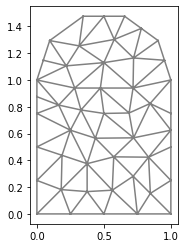

In [23]:
from dolfin import * 
mesh = UnitSquareMesh(10, 10)

V = VectorFunctionSpace(mesh, "CG", 1)
x = SpatialCoordinate(mesh)
disp = project(as_vector((x[1],0)), V)

disp_bc = DirichletBC(V, disp, "near(x[1], 1)")
b_disp = Function(V)
disp_bc.apply(b_disp.vector())

outfile = File("mesh.pvd")
outfile << mesh
ALE.move(mesh, b_disp)
outfile << mesh
for i in range(100):
    mesh.smooth()
    outfile << mesh

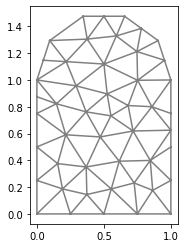

In [24]:
mesh2d.smooth(30)
plot(mesh2d)

In [ ]:
domain.set_subdomain(1, Rectangle(dolfin.Point(1., 1.), dolfin.Point(4., 3.)))
domain.set_subdomain(2, Rectangle(dolfin.Point(2., 2.), dolfin.Point(3., 4.)))

Verbose output of 2D geometry:


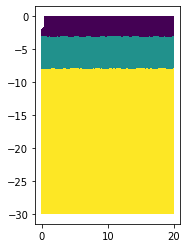

In [3]:

from dolfin import *
from mshr import *

r=0.4
domain =   Rectangle(dolfin.Point(0., 0.), dolfin.Point(20.,-30.)) \
         - Polygon([Point(0, -2),Point(r, -2+r), Point(r, 0), Point(0, 0)])
domain.set_subdomain(1, Rectangle(dolfin.Point(0, 0), dolfin.Point(20, -3)))
domain.set_subdomain(2, Rectangle(dolfin.Point(0, -3), dolfin.Point(20, -8)))
domain.set_subdomain(3, Rectangle(dolfin.Point(0, -8), dolfin.Point(20, -30)))




print("Verbose output of 2D geometry:")
dolfin.info(domain, True)

# Generate and plot mesh
mesh2d = generate_mesh(domain, 45)
# print(mesh2d)

# dolfin.plot(mesh2d, "2D mesh")

# Convert subdomains to mesh function for plotting
mf = dolfin.MeshFunction("size_t", mesh2d, 2, mesh2d.domains())
dolfin.plot(mf, "Subdomains")


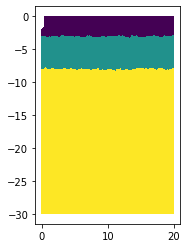

In [6]:
dolfin.plot(mf, "Subdomains")

In [5]:
mesh2d.smooth(30)

In [29]:
mesh2d

Verbose output of 2D geometry:


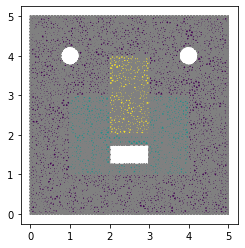

In [9]:
print("Verbose output of 2D geometry:")
dolfin.info(domain, True)

# Generate and plot mesh
mesh2d = generate_mesh(domain, 45)
print(mesh2d)

dolfin.plot(mesh2d, "2D mesh")

# Convert subdomains to mesh function for plotting
mf = dolfin.MeshFunction("size_t", mesh2d, 2, mesh2d.domains())
dolfin.plot(mf, "Subdomains")

In [8]:
Dis=Expression(('x[1]> -1 ? x[0]:0') ,degree=1)
dis2=Expression(('-2'),degree=1)



In [17]:
type((Dis -dis2))

dolfin.function.expression.Expression